# 💹 Analysis of average wages in European countries.

> **Year:** = `2016` <br>

In [3]:
library(eurostat)
library(dplyr)
library(ggplot2)
library(tidyr)
library(moments)
library(patchwork)
library(corrplot)
library(ggpubr)
options(repr.plot.width=30, repr.plot.height=10)

---

# 🔔 Task 1

* Briefly present the distribution of average wages and its characteristics numerically and graphically.
* Discuss which country data might have an impact on average wages.

---

**Step 1: Data Import**:

In [32]:
# Get the dataset
wages_data <- get_eurostat("nama_10_fte")

Dataset query already saved in cache_list.json...

Reading cache file /tmp/RtmpxAPf4y/eurostat/1dfb65851905eb37521e0497fad5f698.rds

Table  nama_10_fte  read from cache file:  /tmp/RtmpxAPf4y/eurostat/1dfb65851905eb37521e0497fad5f698.rds



In [33]:
# Check what objects it has
str(wages_data)

tibble [1,504 × 5] (S3: tbl_df/tbl/data.frame)
 $ freq       : chr [1:1504] "A" "A" "A" "A" ...
 $ unit       : chr [1:1504] "EUR" "EUR" "EUR" "EUR" ...
 $ geo        : chr [1:1504] "AT" "AT" "AT" "AT" ...
 $ TIME_PERIOD: Date[1:1504], format: "1995-01-01" "1996-01-01" ...
 $ values     : num [1:1504] 26543 26522 25943 26863 27714 ...


In [34]:
# Filter it
wages_2016 <- wages_data %>%
  filter(unit == "EUR", TIME_PERIOD == as.Date("2016-01-01")) %>%
  select(geo, values)

In [35]:
# Rename geo codes to actual names
wages_2016 <- label_eurostat(wages_2016, dic = "geo")
View(wages_2016)

geo,values
<chr>,<dbl>
Austria,42876
Belgium,45076
Bulgaria,6767
Cyprus,20759
Czechia,13141
Germany,40902
Denmark,57612
Euro area – 20 countries (from 2023),34411
Estonia,14540


The rows:

"Euro area – 20 countries (from 2023)"

"European Union - 27 countries (from 2020)"

are aggregates, not individual countries. So we will remove them to get more accurate coefficients later.

In [36]:
# Remove non-country aggregate entries
wages_2016 <- wages_2016 %>%
  filter(!geo %in% c("Euro area – 20 countries (from 2023)", 
                     "European Union - 27 countries (from 2020)"))
View(wages_2016)

geo,values
<chr>,<dbl>
Austria,42876
Belgium,45076
Bulgaria,6767
Cyprus,20759
Czechia,13141
Germany,40902
Denmark,57612
Estonia,14540
Greece,16540


---

**Step 2: Descriptive Statistics:**

In [37]:
summary(wages_2016$values)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   6767   12988   21796   26419   40964   62037 

In [38]:
# Calculate the descriptive statistic
mean_wage <- mean(wages_2016$values)
median_wage <- median(wages_2016$values)
sd_wage <- sd(wages_2016$values)
cv_wage <- sd_wage / mean_wage * 100  
skew_wage <- skewness(wages_2016$values)
kurt_wage <- kurtosis(wages_2016$values)
iqr_wage <- IQR(wages_2016$values)

stats_df <- data.frame(
  Statistic = c("Mean", "Median", "Min", "Max", "Range", "Standard Deviation",
                "IQR", "Coefficient of Variation (%)", "Skewness", "Kurtosis"),
  Value = c(mean_wage, median_wage, min(wages_2016$values), max(wages_2016$values),
            max(wages_2016$values) - min(wages_2016$values), sd_wage,
            iqr_wage, cv_wage, skew_wage, kurt_wage)
)

stats_df$Value <- round(stats_df$Value)
print(stats_df)

                      Statistic Value
1                          Mean 26419
2                        Median 21796
3                           Min  6767
4                           Max 62037
5                         Range 55270
6            Standard Deviation 16266
7                           IQR 27976
8  Coefficient of Variation (%)    62
9                      Skewness     1
10                     Kurtosis     2


* `Mean`: The average annual wage across all countries.
* `Median`: The middle value - 50% of countries have wages above this, 50% below.
* `Minimum`: The lowest annual wage among all countries.
* `Maximum`: The highest annual wage.
* `Standard Deviation (sd_wage)`: The average distance of each wage from the mean. High standard deviation means some countries earn much more or much less than the average.
* `Range`: Difference between the max and min wages.
* `IQR (Interquartile Range)`: The difference between the 75th and 25th percentiles. Measures the spread of the middle 50% of wages.
* `Coefficient of Variation (CV)`: Standard deviation divided by the mean, expressed as a percentage. 59% CV means the standard deviation is 59% of the mean.
* `Skewness`: Measures asymmetry of the distribution. European wage data shows positive skewness due to a few very high-wage countries.
* `Kurtosis`: Normal distribution has kurtosis = 3. As we got kurtosis = 2, so the distribution is a bit flatter than normal.


> **We started by analyzing the basic characteristics of the average wage distribution. The mean and median are close, but the difference suggests some skewness. A high standard deviation and coefficient of variation indicate > significant wage disparity across European countries. The positive skewness and medium kurtosis further confirm that a few wealthy countries have higher wages, pulling the distribution to the right.**

---

**Step 3: Visualizations:**

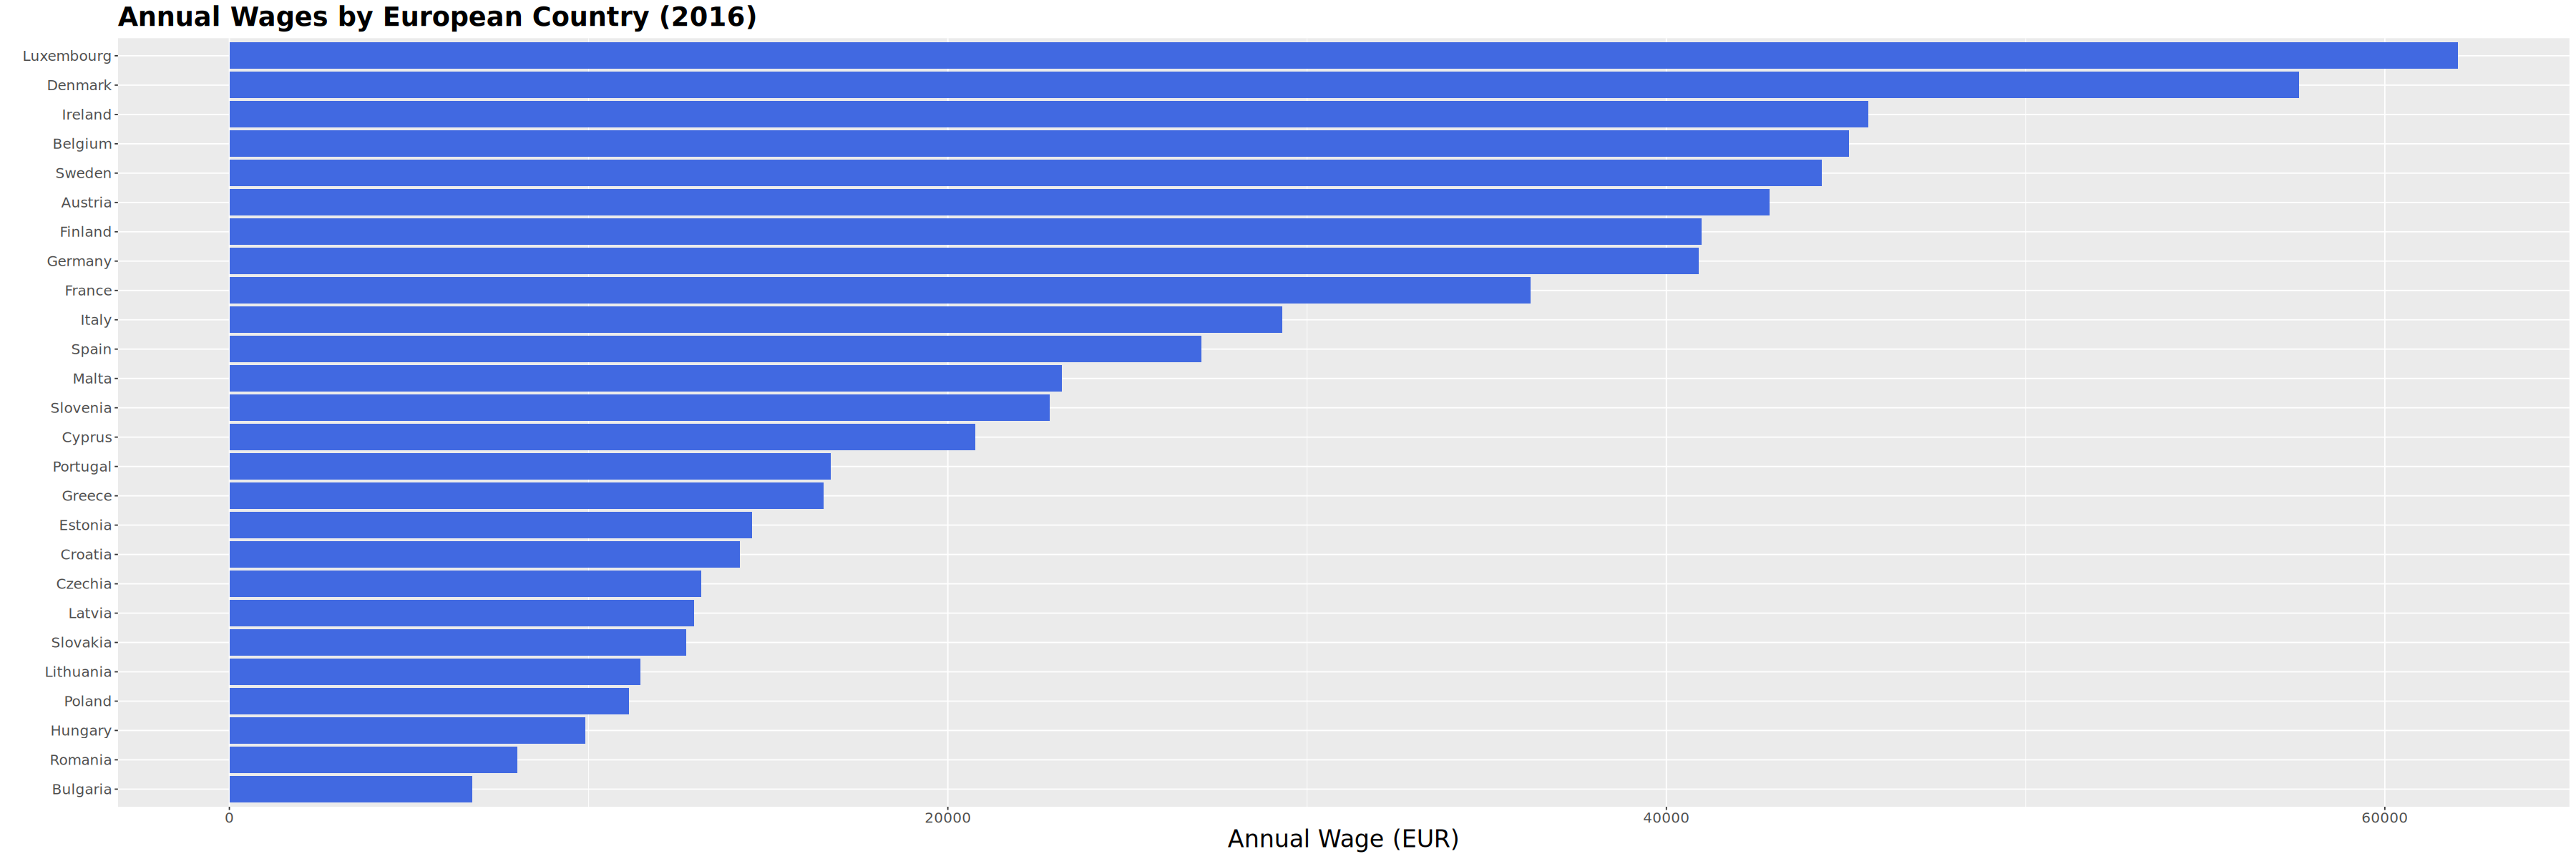

In [39]:
# Bar chart of wages by country
bar_chart <- ggplot(wages_2016 %>% arrange(desc(values)), 
                    aes(x = reorder(geo, values), y = values)) +
  geom_bar(stat = "identity", fill = "royalblue") +
  labs(title = "Annual Wages by European Country (2016)",
       x = "",
       y = "Annual Wage (EUR)") +
  theme(
    text = element_text(size = 14),
    plot.title = element_text(size = 22, face = "bold"),
    axis.title = element_text(size = 20),
    axis.text = element_text(size = 12)
  ) +
  coord_flip()

print(bar_chart)


In [40]:
# Histogram of wages
hist_plot <- ggplot(wages_2016, aes(x = values)) +
  geom_histogram(binwidth = 5000, fill = "steelblue", color = "black", alpha = 0.7) +
  geom_vline(aes(xintercept = mean_wage), color = "red", linetype = "dashed", linewidth = 1) +
  geom_vline(aes(xintercept = median_wage), color = "darkgreen", linetype = "dashed", linewidth = 1) +
  labs(title = "Distribution of Annual Wages in European Countries (2016)",
       subtitle = paste("Mean =", round(mean_wage), "EUR, Median =", round(median_wage), "EUR"),
       x = "Annual Wage (EUR)",
       y = "Number of Countries") +
theme(
    text = element_text(size = 14),
    plot.title = element_text(size = 24, face = "bold"),
    axis.title = element_text(size = 20),
    axis.text = element_text(size = 12)
  )

In [41]:
# Density plot
density_plot <- ggplot(wages_2016, aes(x = values)) +
  geom_density(fill = "lightblue", alpha = 0.7) +
  geom_rug(alpha = 0.5) +
  labs(title = "Density Plot of Annual Wages",
       x = "Annual Wage (EUR)",
       y = "Density")  + 
theme(
    text = element_text(size = 14),
    plot.title = element_text(size = 24, face = "bold"),
    axis.title = element_text(size = 20),
    axis.text = element_text(size = 12)
  )

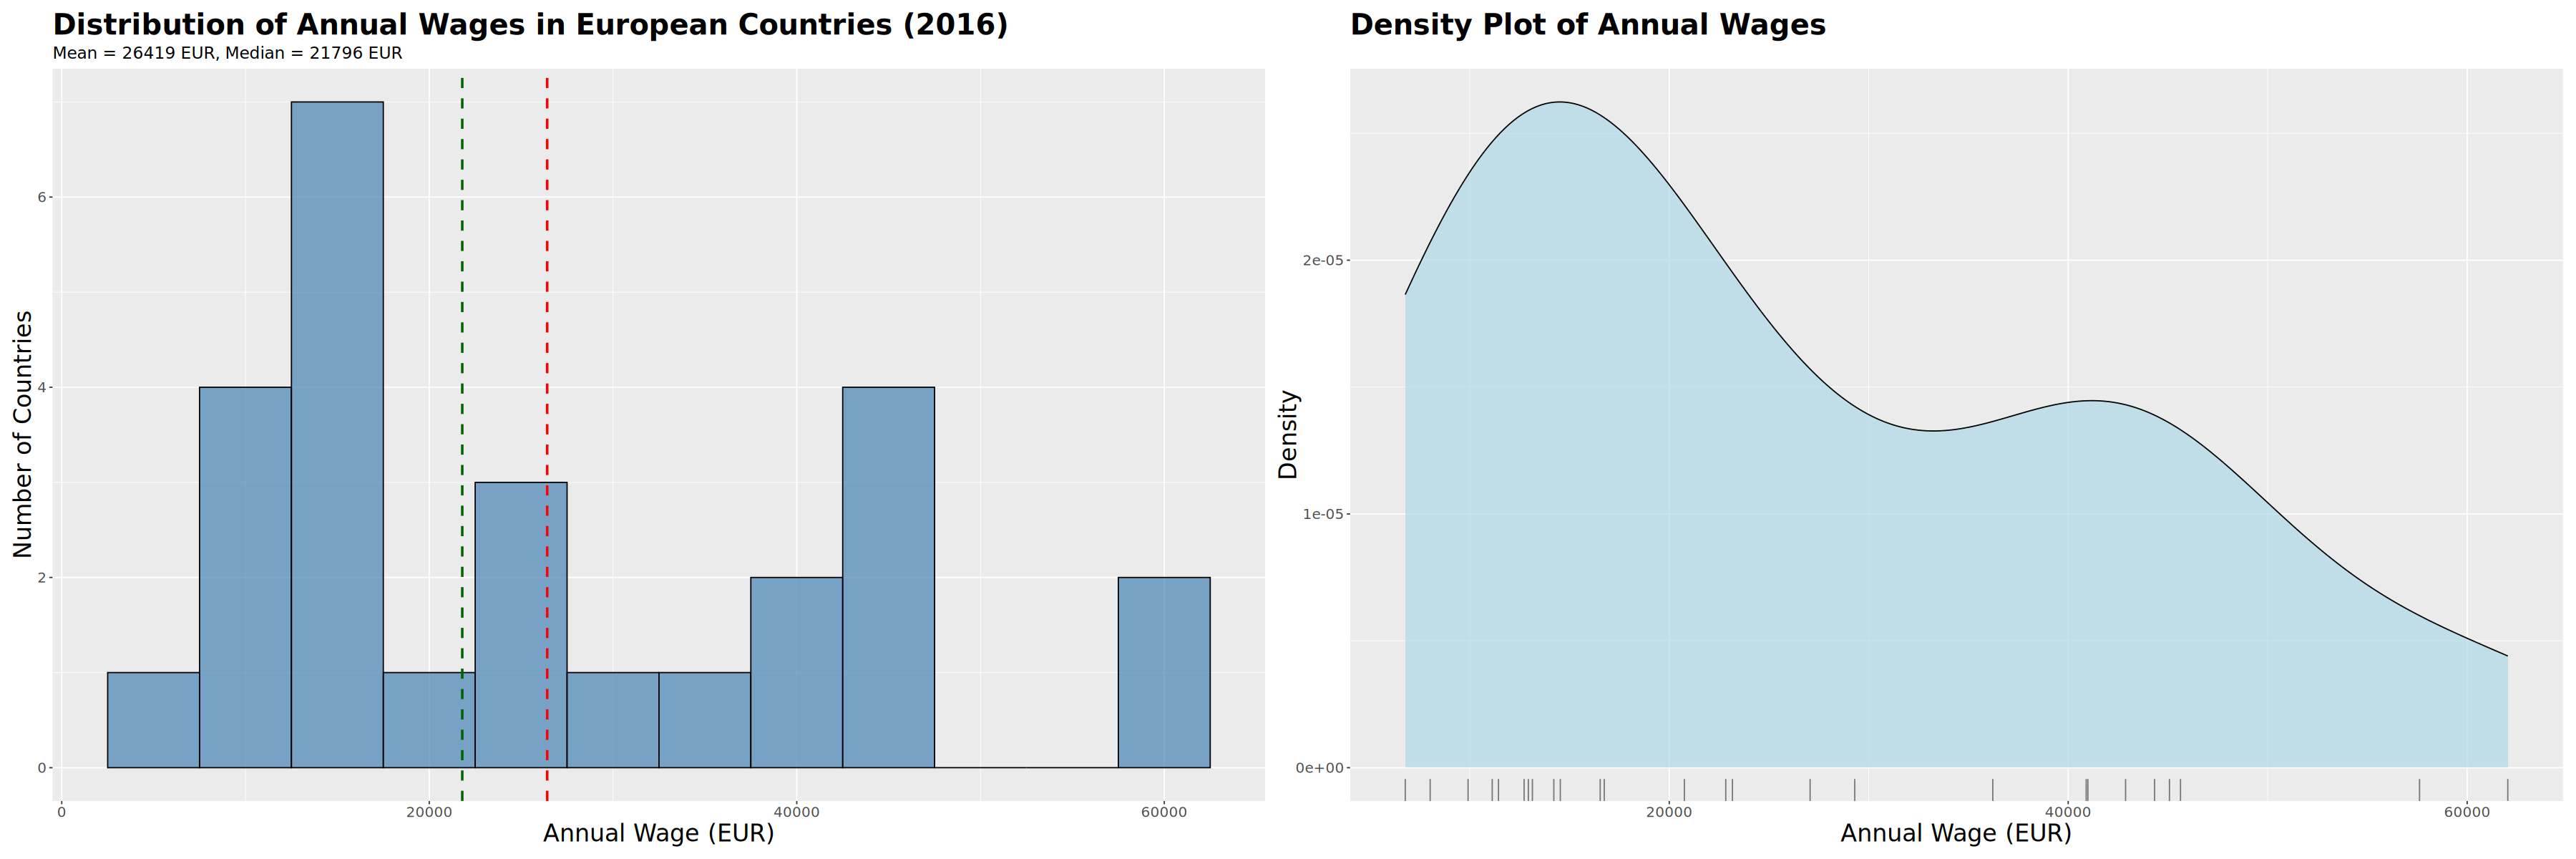

In [42]:
(hist_plot | density_plot)

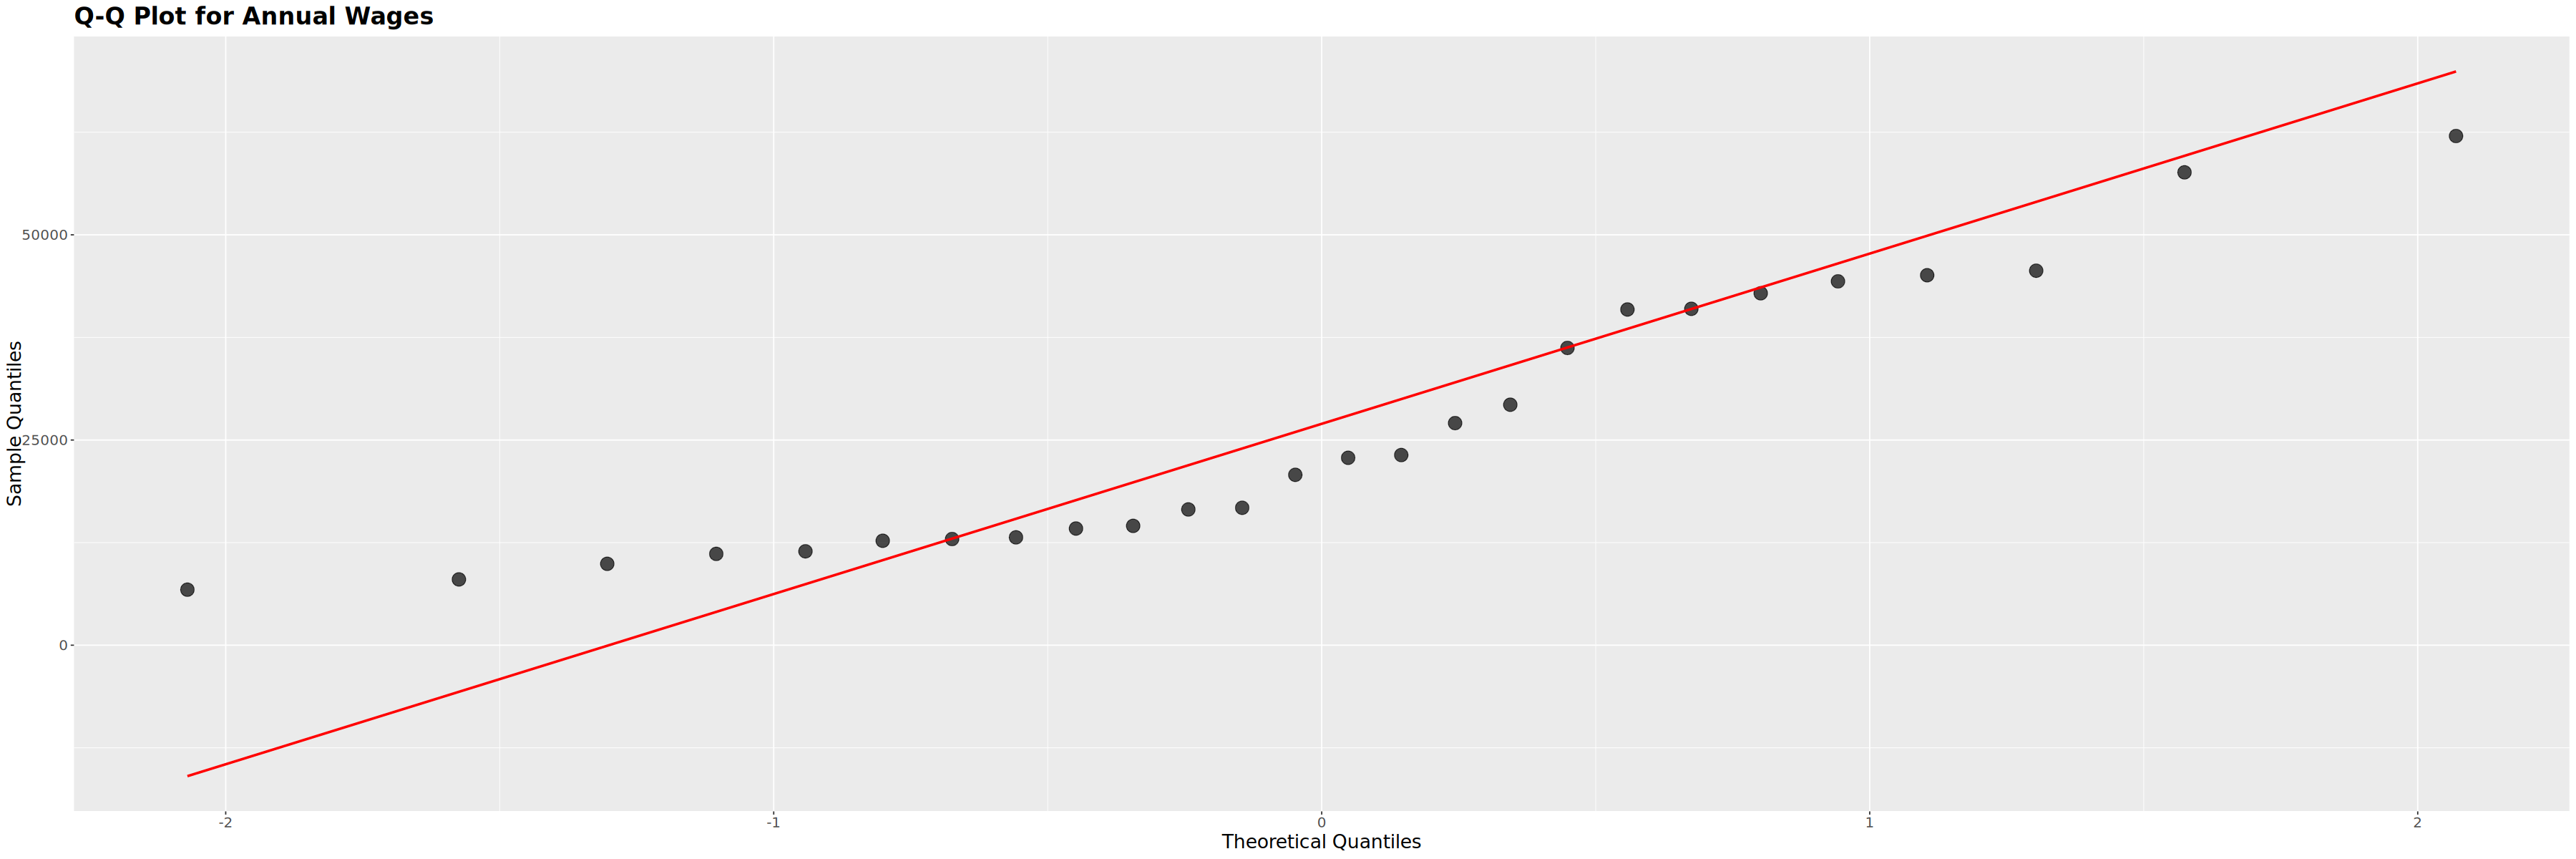

In [43]:
# QQ plot to check normality
qq_plot <- ggplot(wages_2016, aes(sample = values)) +
  stat_qq(size = 5, color = "black", alpha = 0.7) +
  stat_qq_line(color = "red", size = 1) +
  labs(title = "Q-Q Plot for Annual Wages",
       x = "Theoretical Quantiles",
       y = "Sample Quantiles") + 
    theme(
  text = element_text(size = 14),
  plot.title = element_text(size = 20, face = "bold"),
  axis.title = element_text(size = 16),
  axis.text = element_text(size = 12)
    )

print(qq_plot)

> **As we can see, the points show a slight S-shape, it indicates skewness.**

---

**Step 4: Discuss which factors might influence average wages in European countries**

>Examining economic, demographic, geographical, political, and monetary contexts let us explain why some countries consistently report higher average wages than others.
>
>1. **Economic Factors**
>* `Inflation Rate`:
>Inflation influences the real purchasing power of wages. Countries with high inflation may show increasing nominal wages, but the real value of these earnings diminishes over time. For example, if wages grow slower than inflation, workers may actually be earning less in real terms. Countries with stable or low inflation (like Germany or Switzerland) tend to maintain better wage purchasing power.
>
>* `GDP per Capita`:
>Gross Domestic Product (GDP) per capita is a strong indicator of a country's economic health. Countries with high GDP per capita often have more developed infrastructures, stronger industries, and higher productivity - all of which drive higher wages. Western European countries like Luxembourg or Ireland illustrate how a high GDP per capita is usually associated with better average earnings.
>
>2. **Demographic Factors**
>* `Education Levels`:
>The level of education in a population directly affects the skill level of the workforce. Countries with a high percentage of tertiary education graduates typically have more professionals in high-paying industries (e.g., technology, finance, medicine). Education also promotes innovation and entrepreneurship, further stimulating wage growth. For example, countries like Finland or the Netherlands, which prioritize education, often report above-average wages.
>
>3. **Geographical Factors**
>* `Access to Natural Resources`:
>Countries rich in natural resources (e.g., oil, gas, minerals) can afford to pay higher wages in sectors tied to resource extraction and energy. Norway is a prime example - its wealth from oil and gas exports contributes to some of the highest wages in Europe.
>
>* `Access to a Sea`:
>Landlocked countries may face higher trade costs, reduced tourism potential, and logistical challenges that can limit economic growth and wage development. In contrast, countries with sea access benefit from trade routes, ports, tourism, and fishing industries, which can boost economic activity and wage levels. Coastal countries like Denmark or Spain may see advantages in wage growth due to these factors.
>
>4. **Political and Legal Factors**
>* `Type of Government: Monarchy vs. Democracy`:
>While the form of government (monarchy or democracy) might not directly dictate wages, democratic systems generally correlate with better labor rights, stronger unions, and inclusive economic policies. These structures may promote fairer wage distribution and stronger social support systems. Most European democracies support minimum wage laws and collective bargaining, contributing to higher wage floors.
>
>5. **Currency Factors**
>* `Currency Strength`:
>The strength of a country's currency impacts how its wages compare internationally. Countries with stronger currencies (e.g., CHF in Switzerland, NOK in Norway) often report higher wages when converted to euros. However, currency strength also affects cost of living, so while nominal wages may be high, real purchasing power should also be considered.

---

# 🔔 Task 2

* For the countries under consideration, choose four data available from Eurostat databases or other external sources as appropriate. These may be demographic, geographical or economic indicators. At least one variable should be numerical and at least one categorical (e.g. whether the country has access to the sea, whether the country pays in euros, whether it is a monarchy or a republic,...).
* These data will serve as regressors, so choose them so that they determine the variable being modelled at least to a minimum extent. Check the relationship with wages.
* Present the important properties of the chosen indicators numerically and graphically.
* Use appropriate tests to investigate the relationships between the regressors.
---

**Step 1: Choosing 4 Regressors**

1. **GDP per capita (EUR)**

* Type: `Numeric`
* Source: `Eurostat (nama_10_pc)`
* Why it's relevant: GDP per capita reflects a country's economic strength and standard of living. It's often strongly associated with wage levels because wealthier countries can generally afford to pay higher wages.

2. **Tertiary education rate**

* Type: `Numeric`
* Source: `Eurostat (edat_lfse_03)`
* Why it's relevant: A higher proportion of the population with tertiary education typically leads to a more skilled workforce, which is correlated with higher average wages.

3. **Access to sea (Yes/No)**

* Type: `Categorical`
* Source: `Manual assignment`
* Why it's relevant: Countries with access to the sea may have economic advantages through trade, fishing, and tourism, which can contribute to higher national income and wages.

4. **Use of Euro (Yes/No)**

* Type: `Categorical`
* Source:  `Manual assignment`
* Why it's relevant: Being part of the Eurozone can bring monetary stability and closer economic ties with stronger economies, which may have a positive impact on wages.

---

**Step 2: Assigning Values**

* *GDP per capita (EUR):*

In [44]:
gdp_data <- get_eurostat("nama_10_pc", time_format = "num", type = "code")
gdp_data <- label_eurostat(gdp_data)
gdp_2016 <- gdp_data %>%
  filter(TIME_PERIOD == 2016, unit == "Current prices, euro per capita", na_item == "Gross domestic product at market prices") %>%
  select(geo, values) %>%
  rename(gdp_per_capita = values)
wages_2016 <- wages_2016 %>%
  left_join(gdp_2016, by = "geo")

Dataset query already saved in cache_list.json...

Reading cache file /tmp/RtmpxAPf4y/eurostat/1bd557bd09ff90675430496bde17c1b0.rds

Table  nama_10_pc  read from cache file:  /tmp/RtmpxAPf4y/eurostat/1bd557bd09ff90675430496bde17c1b0.rds



---

* *Tertiary education rate:*

In [45]:
edu_data <- get_eurostat("edat_lfse_03", time_format = "num", type = "code")
edu_data <- label_eurostat(edu_data)
edu_data <- edu_data %>%
  filter(age == "From 15 to 64 years", sex == "Total", isced11 == "Tertiary education (levels 5-8)", TIME_PERIOD == 2016) %>%
  select(geo, values) %>%
  rename(education = values)
wages_2016 <- wages_2016 %>%
  left_join(edu_data, by = "geo")

Dataset query already saved in cache_list.json...

Reading cache file /tmp/RtmpxAPf4y/eurostat/d383953394edb5cbcc68d4d6150665ee.rds

Table  edat_lfse_03  read from cache file:  /tmp/RtmpxAPf4y/eurostat/d383953394edb5cbcc68d4d6150665ee.rds



---

* *Access to sea:*

In [46]:
landlocked <- c("Austria", "Czechia", "Hungary", "Luxembourg", "Slovakia")
wages_2016$sea_access <- ifelse(wages_2016$geo %in% landlocked, "No", "Yes")

---

* *Use of Euro:*

In [47]:
eurozone <- c(
  "Austria", "Belgium", "Cyprus", "Croatia", "Estonia", "Finland", "France", "Germany", 
  "Greece", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", 
  "Malta", "Netherlands", "Portugal", "Slovakia", "Slovenia", "Spain"
)
wages_2016$eurozone <- ifelse(wages_2016$geo %in% eurozone, "Yes", "No")

---

In [48]:
View(wages_2016)

geo,values,gdp_per_capita,education,sea_access,eurozone
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Austria,42876,40690,28.9,No,Yes
Belgium,45076,37810,33.2,Yes,Yes
Bulgaria,6767,7070,24.4,Yes,No
Cyprus,20759,21930,37.6,Yes,Yes
Czechia,13141,17040,20.6,No,No
Germany,40902,38810,24.4,Yes,Yes
Denmark,57612,49270,31.1,Yes,No
Estonia,14540,16860,33.1,Yes,Yes
Greece,16540,16190,26.4,Yes,Yes


In [49]:
summary(wages_2016)

     geo                values      gdp_per_capita    education    
 Length:26          Min.   : 6767   Min.   : 7070   Min.   :15.10  
 Class :character   1st Qu.:12988   1st Qu.:13875   1st Qu.:20.80  
 Mode  :character   Median :21796   Median :20655   Median :28.05  
                    Mean   :26419   Mean   :27602   Mean   :27.67  
                    3rd Qu.:40964   3rd Qu.:38560   3rd Qu.:33.17  
                    Max.   :62037   Max.   :96230   Max.   :39.50  
  sea_access          eurozone        
 Length:26          Length:26         
 Class :character   Class :character  
 Mode  :character   Mode  :character  
                                      
                                      
                                      

**Step 3: Numerical and Graphical Summary**

* Descriptive statistics for numeric variables

In [50]:
summary(wages_2016$gdp_per_capita)
summary(wages_2016$education)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   7070   13875   20655   27602   38560   96230 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15.10   20.80   28.05   27.67   33.17   39.50 

* Boxplot for Sea Access vs Wages

In [51]:
sea_plot <- ggplot(wages_2016, aes(x = sea_access, y = values, fill = sea_access)) +
  geom_boxplot() +
  labs(title = "Annual Wage by Sea Access",
       x = "Sea Access",
       y = "Annual Wage (EUR)") + 
    theme(
  text = element_text(size = 14),
  plot.title = element_text(size = 20, face = "bold"),
  axis.title = element_text(size = 16),
  axis.text = element_text(size = 12)
    )

* Boxplot for Eurozone Membership vs Wages

In [52]:
euro_plot <- ggplot(wages_2016, aes(x = eurozone, y = values, fill = eurozone)) +
  geom_boxplot() +
  labs(title = "Annual Wage by Eurozone Membership",
       x = "Eurozone Membership",
       y = "Annual Wage (EUR)") + 
    theme(
  text = element_text(size = 14),
  plot.title = element_text(size = 20, face = "bold"),
  axis.title = element_text(size = 16),
  axis.text = element_text(size = 12)
    )

* Scatter plot with regression for GDP

In [53]:
plot_gdp <- ggplot(wages_2016, aes(x = gdp_per_capita, y = values)) +
  geom_point(size = 3) +
  geom_smooth(method = "lm", formula = y ~ x, color = "red", se = TRUE) +
  labs(title = "GDP per Capita vs Average wage",
       x = "GDP per Capita (EUR)",
       y = "Average wage (EUR)") + 
    theme(
  text = element_text(size = 14),
  plot.title = element_text(size = 20, face = "bold"),
  axis.title = element_text(size = 16),
  axis.text = element_text(size = 12)
    )

* Scatter plot with regression for Education

In [54]:
plot_edu <- ggplot(wages_2016, aes(x = education, y = values)) +
  geom_point(size = 3) +
  geom_smooth(method = "lm", color = "red", formula = y ~ x, se = TRUE) +
  labs(title = "Tertiary Education Rate vs Annual Wage",
       x = "Tertiary Education Rate (%)",
       y = "Annual Wage (EUR)") + 
    theme(
  text = element_text(size = 14),
  plot.title = element_text(size = 20, face = "bold"),
  axis.title = element_text(size = 16),
  axis.text = element_text(size = 12)
    )

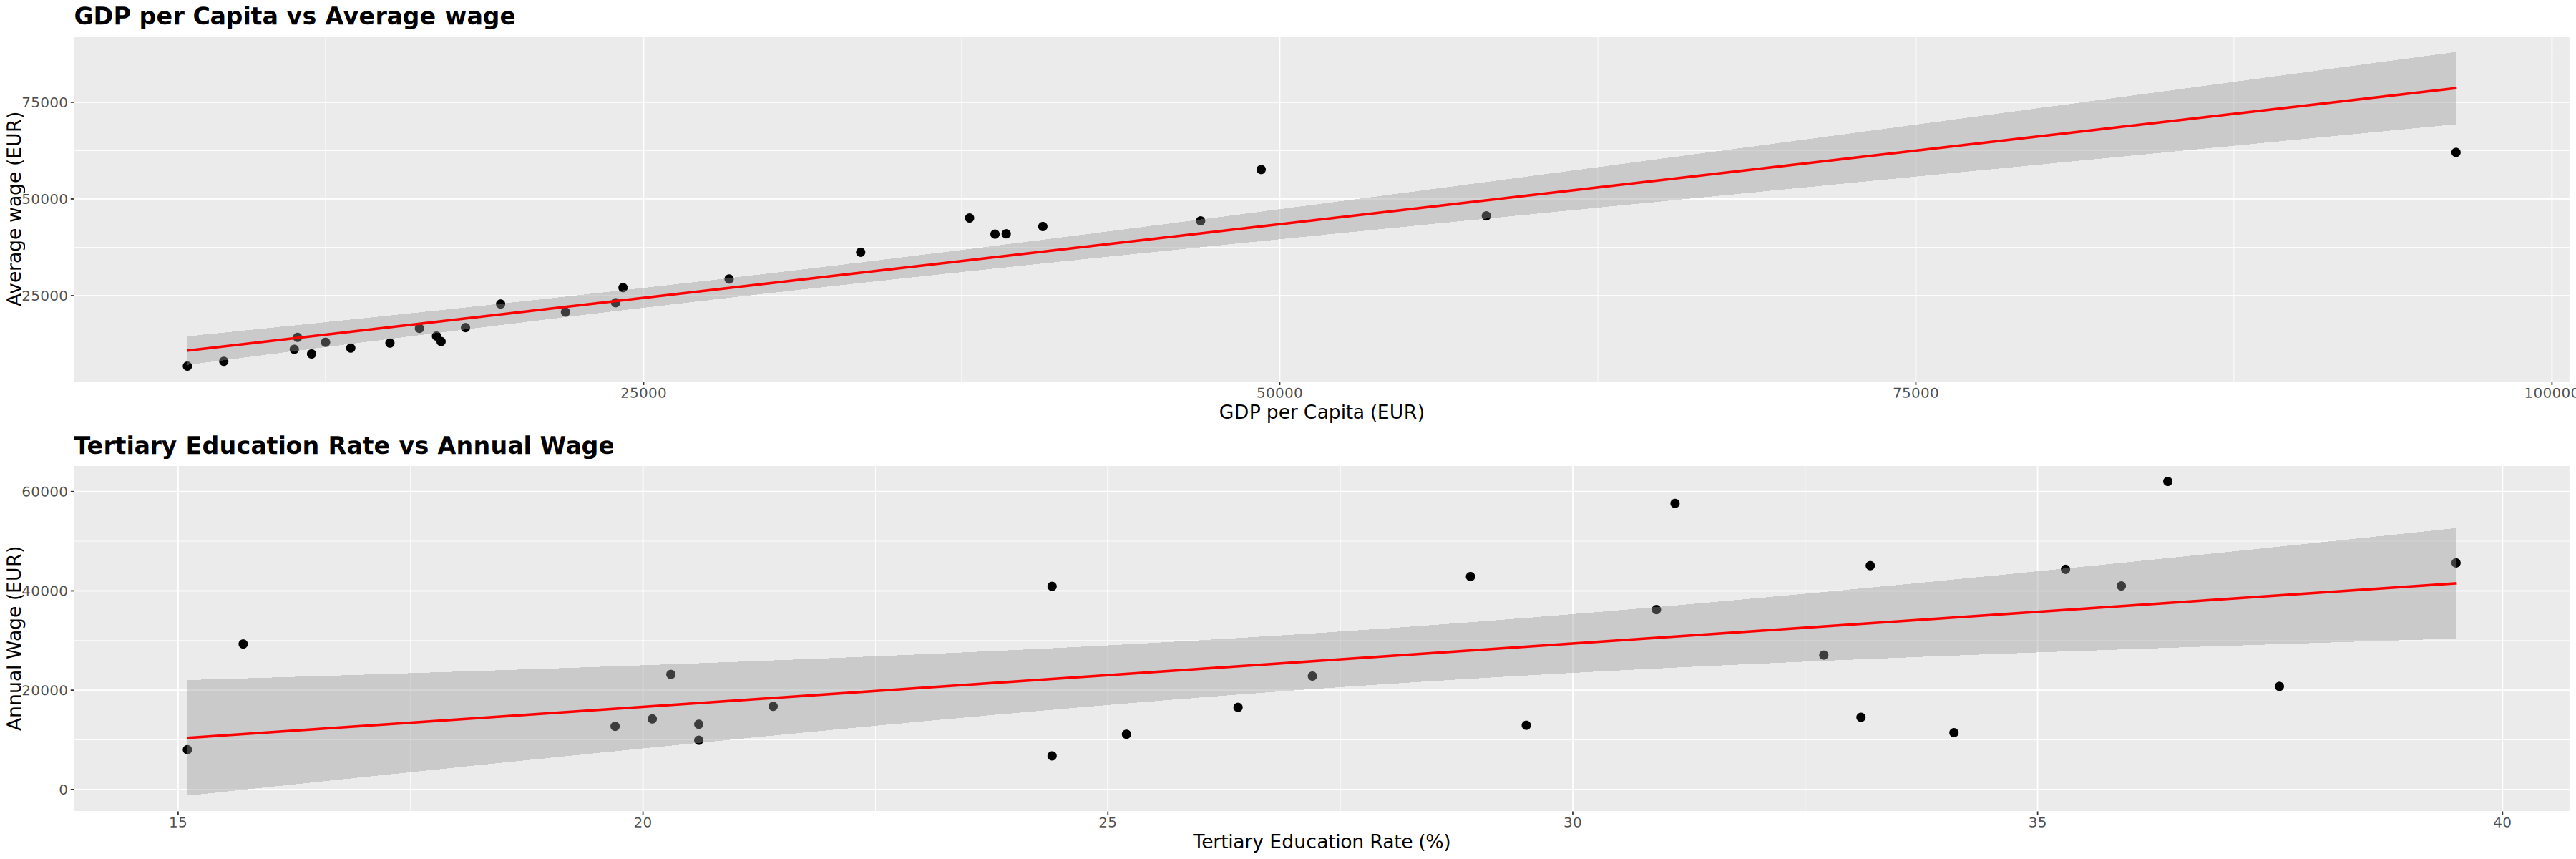

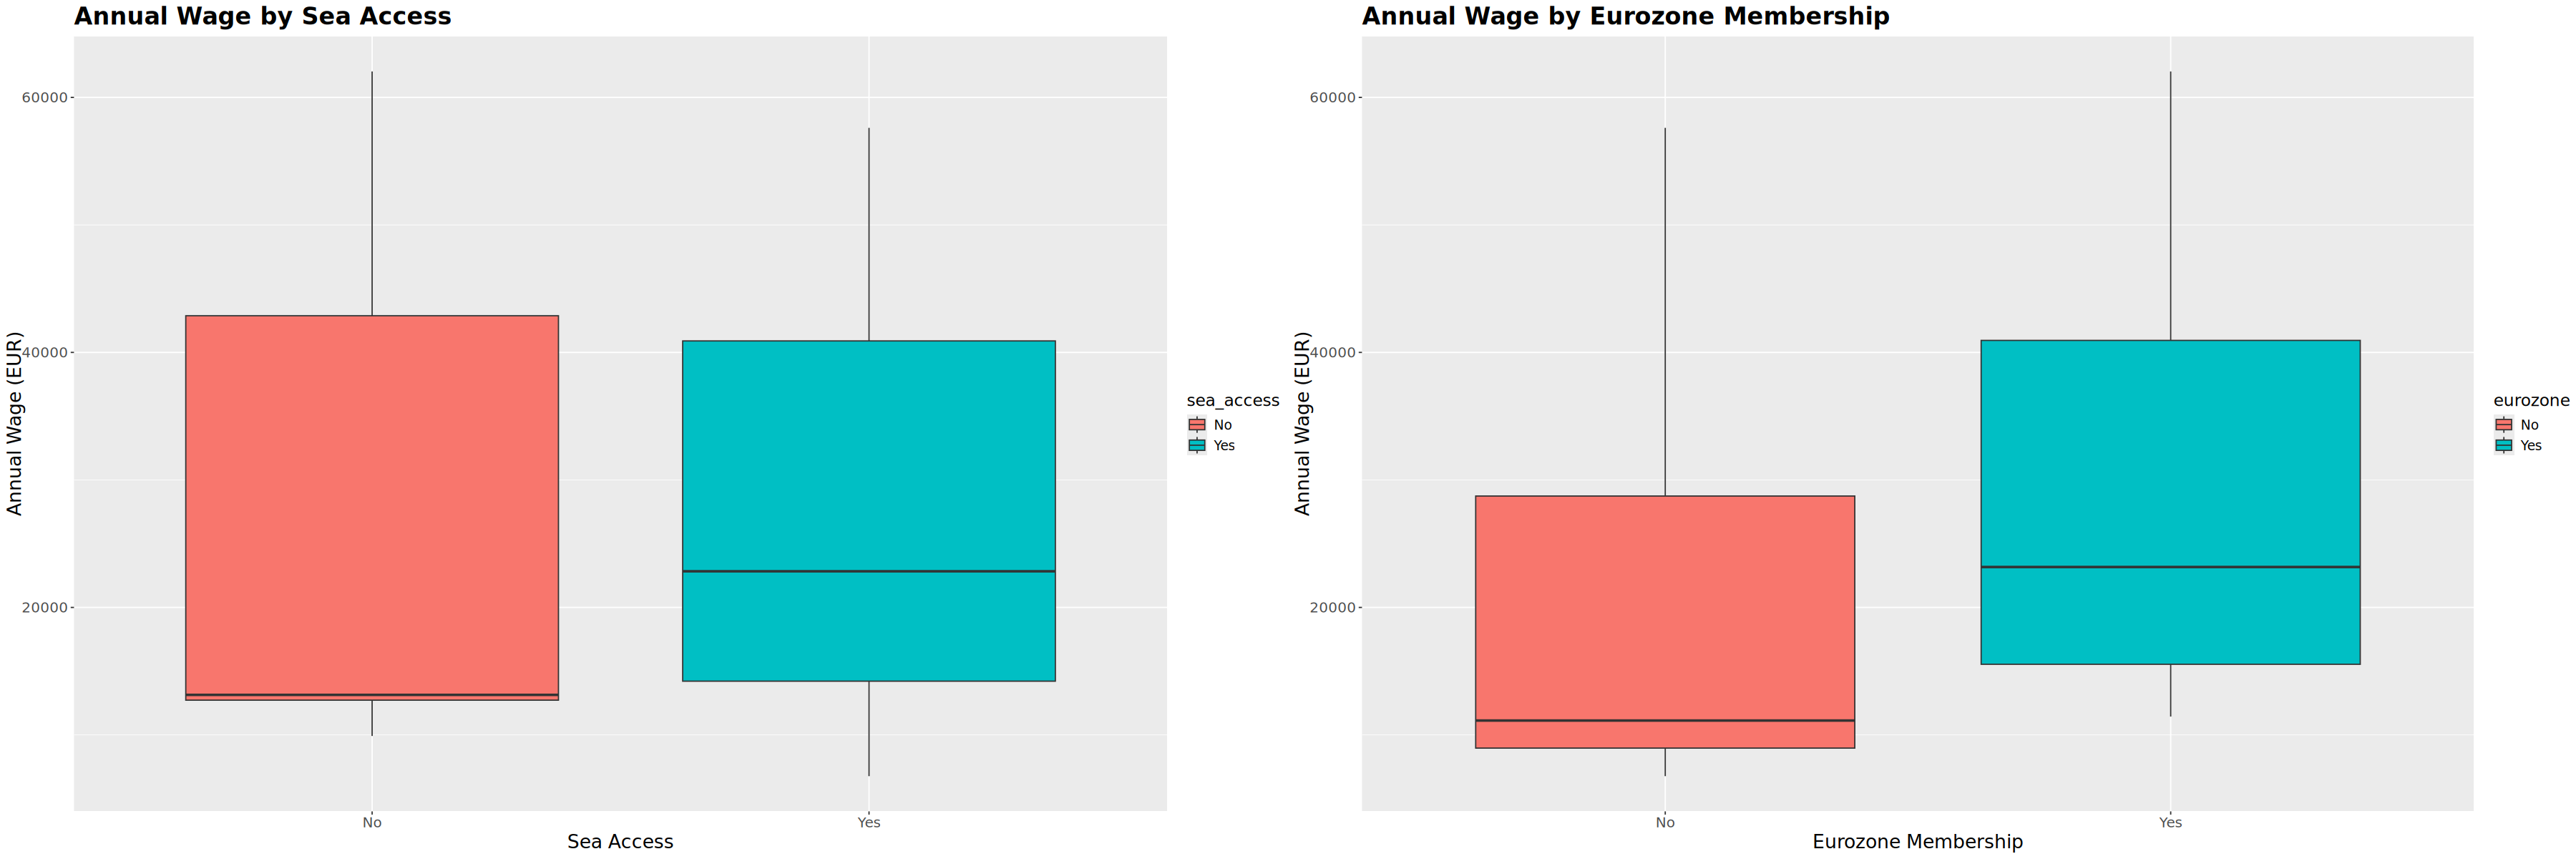

In [55]:
ggarrange(plot_gdp, plot_edu, ncol = 1, nrow = 2)
ggarrange(sea_plot, euro_plot, ncol = 2)

---

* Check for association between sea access and Eurozone membership:

In [57]:
table1 <- table(wages_2016$eurozone, wages_2016$sea_access)
fisher.test(table1)


	Fisher's Exact Test for Count Data

data:  table1
p-value = 0.5875
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.1362075 24.2955784
sample estimates:
odds ratio 
  2.065338 


> * p-value =  0.5875 (This is much higher than the standard significance level (e.g., 0.05))
> → This means there's no evidence of association between the two variables.
> 
> * Odds ratio = 2.07
> → Suggests countries in the eurozone are about twice as likely to have sea access — but the wide confidence interval (0.136 to 24.296) shows high uncertainty.
> 
> * 95% Confidence Interval: (0.136 to 24.296)
> → A very wide interval, which includes 1, indicating high uncertainty and again no strong evidence of a real effect.
> 
> 
> Although the odds ratio suggests a small association, the p-value and wide confidence interval mean that we cannot conclude there's a statistically significant relationship between sea access and Euro usage in our data.

---

* Create correlation matrix and make correlation tests:

[1] 0.9255827

[1] 0.5520679


	Welch Two Sample t-test

data:  values by sea_access
t = 0.19552, df = 4.811, p-value = 0.853
alternative hypothesis: true difference in means between group No and group Yes is not equal to 0
95 percent confidence interval:
 -26199.79  30458.36
sample estimates:
 mean in group No mean in group Yes 
         28139.00          26009.71 



	Welch Two Sample t-test

data:  values by eurozone
t = -0.7858, df = 8.3509, p-value = 0.4537
alternative hypothesis: true difference in means between group No and group Yes is not equal to 0
95 percent confidence interval:
 -26027.95  12725.59
sample estimates:
 mean in group No mean in group Yes 
         21558.71          28209.89 


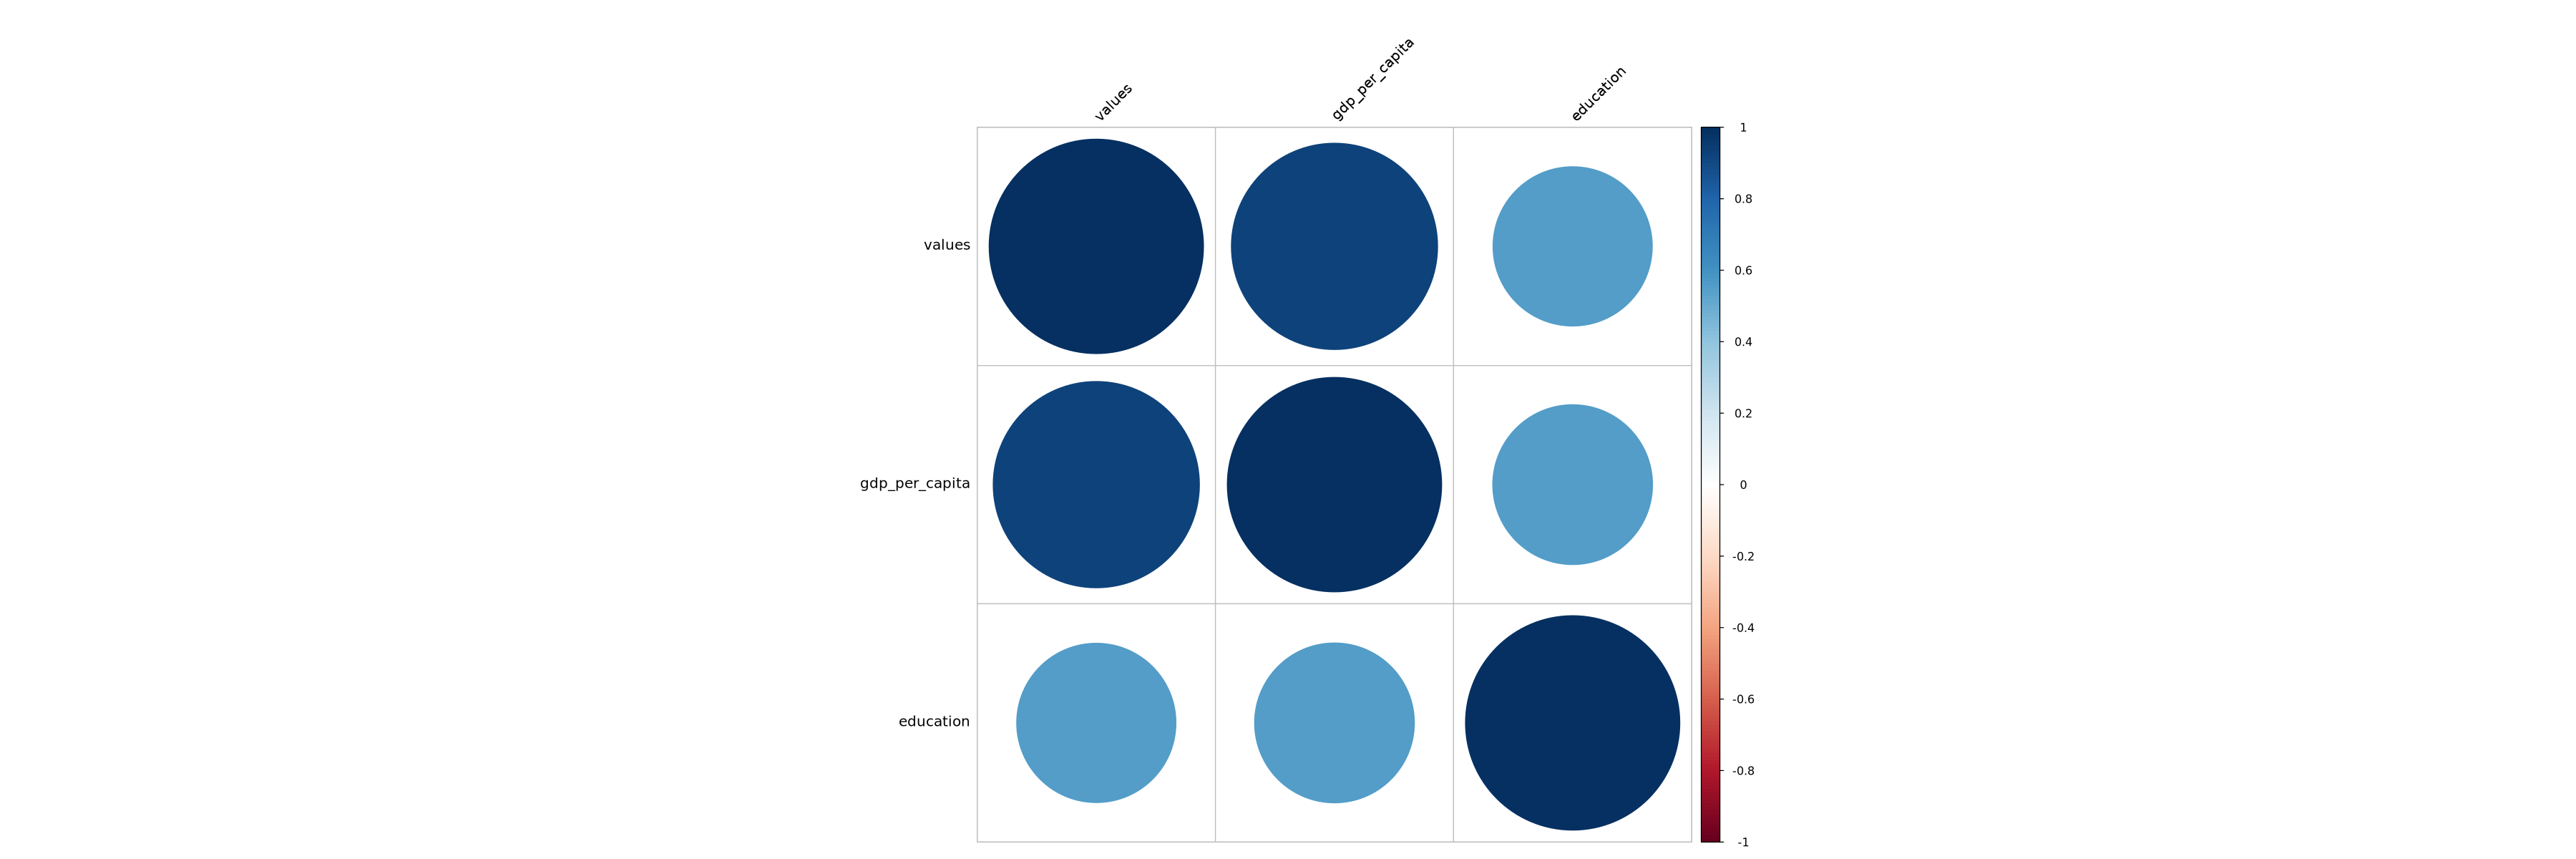

In [58]:
cor(wages_2016$gdp_per_capita, wages_2016$values)
cor(wages_2016$education, wages_2016$values)

# t-test for categorical variables
t.test(values ~ sea_access, data = wages_2016)
t.test(values ~ eurozone, data = wages_2016)

# corr matrix
cor_matrix <- cor(wages_2016[, c("values", "gdp_per_capita", "education")])

corrplot(cor_matrix, tl.col = "black", tl.srt = 45)

**Summary:** 

>The numerical variables, GDP per capita and education, show positive correlations with average wages. **GDP** per capita has a particularly strong correlation of approximately `0.93`, suggesting it is a strong predictor of wages. Education also shows a moderate positive correlation with wages, with a correlation coefficient of approximately `0.55`.
>
>The *t-tests* for categorical variables indicate that there are no statistically significant differences in wages based on **sea access** or **Eurozone membership**.
>
>Specifically:
>
>* For **sea access**, the p-value is `0.853`, and the `95%` confidence interval for the difference in means is `[-26199.79, 30458.36]`, which includes zero.
>
>* For **Eurozone membership**, the p-value is `0.454`, and the `95%` confidence interval for the difference in means is `[-26027.95, 12725.59]`, which also includes zero.
>
>* The correlation matrix visualization indicates that there is no significant multicollinearity concern among the predictors, as the correlations between them are moderate. This supports the use of all relevant predictors in a regression model.



---

# 🔔 Task 3

* Using a linear regression model or its variants, examine the dependence of wages on all regressors.
* Practically interpret the values of the estimated regression coefficients.
* Evaluate the quality of the model.
* Identify outliers and examine multicollinearity.
* Test the model assumptions — if they are not met, propose and try methods that compensate for the violations or do not rely on those assumptions.
* Using appropriate tools, try to find a final (sub-)model that explains the behavior of wages well but does not include insignificant components. Practically interpret the obtained results.

#### **Step 1: Build the linear regression model and interpret the results**

In [122]:
# Fit the linear regression model
model <- lm(values ~ gdp_per_capita + education + sea_access + eurozone, data = wages_2016)

# Show the summary
summary(model)


Call:
lm(formula = values ~ gdp_per_capita + education + sea_access + 
    eurozone, data = wages_2016)

Residuals:
     Min       1Q   Median       3Q      Max 
-13470.5  -3786.4   -368.8   2232.7  12398.3 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     192.46702 5322.26852   0.036   0.9715    
gdp_per_capita    0.79651    0.08129   9.798 2.77e-09 ***
education       -22.83827  227.77488  -0.100   0.9211    
sea_accessYes  6487.40364 3389.47906   1.914   0.0693 .  
eurozoneYes    -501.96438 2851.46567  -0.176   0.8620    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6154 on 21 degrees of freedom
Multiple R-squared:  0.8798,	Adjusted R-squared:  0.8568 
F-statistic: 38.41 on 4 and 21 DF,  p-value: 2.244e-09


#### Interpretation

We modeled the average annual wage per person (`values`) as a function of four explanatory variables: `gdp_per_capita`, `education`, `sea_access`, and `eurozone`.

- **R-squared** = **0.88**: Approximately 88% of the variance in wages is explained by the model.
- **Adjusted R-squared** = **0.86**: Adjusted for the number of predictors, still very high.
- **Residual standard error** = **5912**: On average, the model's wage predictions differ from actual values by about €5912.
- **F-statistic** = **38.41**, **p-value** = **2.24e-09**: The overall model is statistically significant, meaning at least one predictor significantly contributes to explaining the wages.

#### Interpretation of Coefficients
- **Intercept (192.47)**: This is the baseline predicted wage when all predictors are zero. Since zero values for GDP per capita or education aren’t realistic, the intercept has no practical interpretation here.
- **GDP per capita (0.7965, p < 0.001)**: Statistically significant. For every €1 increase in GDP per capita, the average wage increases by approximately €0.80, holding other variables constant.
- **Education (-22.84, p = 0.921)**: Not statistically significant. The share of the population with tertiary education does not have a meaningful linear relationship with wages in this model.
- **Sea access ("Yes" = 6487.40, p = 0.069)**: Marginally significant. Countries with access to the sea have, on average, €6487 higher wages than landlocked countries, controlling for other factors. The p-value suggests this effect is borderline significant at the 10% level.
- **Eurozone membership ("Yes" = -501.96, p = 0.862)**: Not statistically significant. Being in the Eurozone does not show a significant impact on wages in this model.

#### Key Findings
- **GDP per capita** is the strongest and most reliable predictor of wages.
- **Sea access** also has a notable positive effect on wages.
- **Education** and **Eurozone membership** do not significantly affect wages in this model and might be reconsidered in the final model.
- The model explains a very high proportion of variance, making it a strong explanatory model.

#### **Step 2: Identify outliers and examine multicollinearity**
Firstly we will look on Studentized Residuals (to detect outliers in the response).

In [123]:
# Load necessary package
library(MASS)

# Get studentized residuals
student_res <- rstudent(model)

# Check which observations have |residual| > 3
which(abs(student_res) > 3)

18 
18

 - The observation with `index 18` is flagged as having a studentized residual greater than 3. It suggests that this observation is an extreme point and may be an outlier.
 - Since there’s only one such observation, it could be influential in our regression model.

Then let's check Cook’s Distance (to detect influential observations).

1  7 18 
 1  7 18

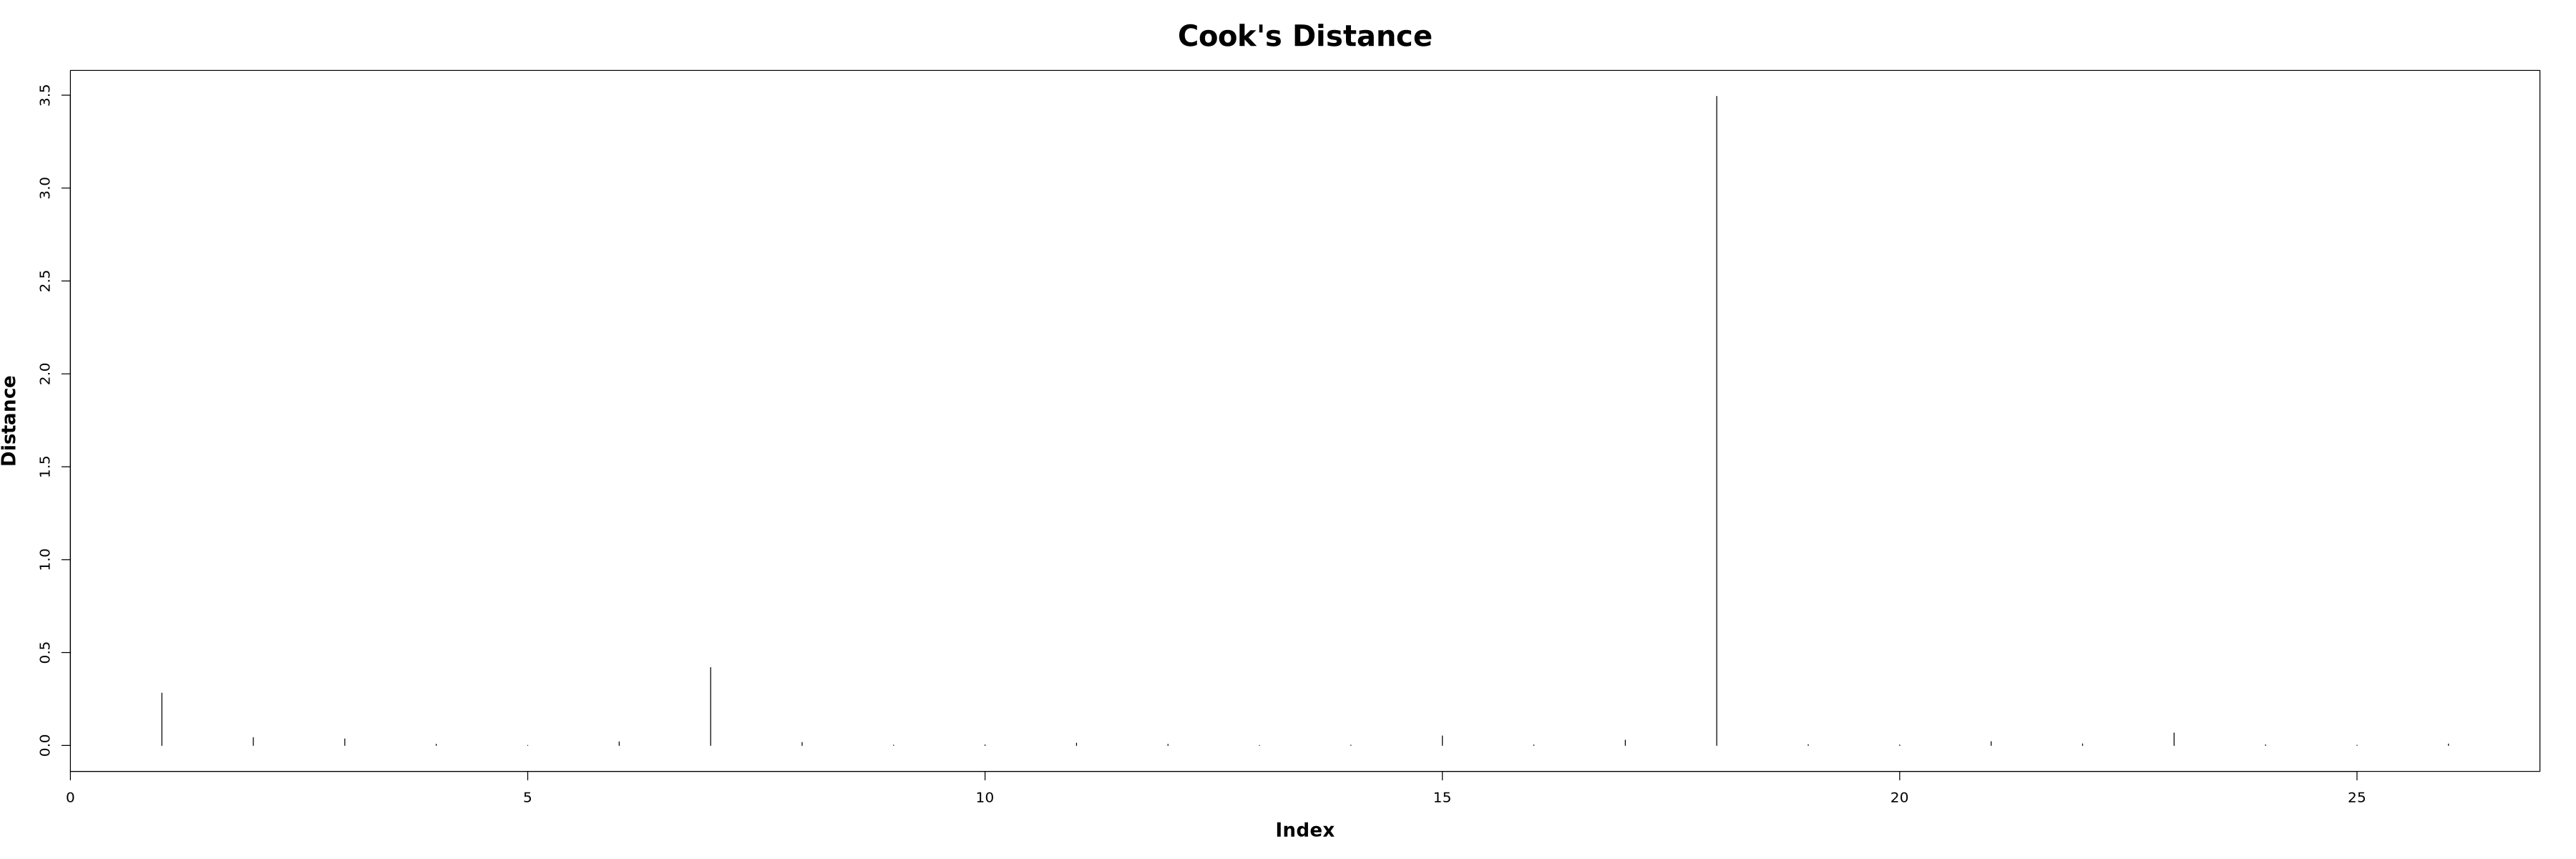

In [124]:
# Calculate Cook's distance
cooks_d <- cooks.distance(model)

# Plot Cook’s distance with bigger text and bold labels
plot(cooks_d, type = "h", main = "Cook's Distance", ylab = "Distance", 
     cex.main = 2, cex.lab = 1.3, font.main = 2, font.lab = 2)


# Flag observations with Cook's D > 4/n
n <- nrow(wages_2016)
which(cooks_d > 4/n)

   * Observations flagged by Cook's distance:

     * **Observation 1, 7, 18** are flagged as influential, with Cook's D values greater than $\frac{4}{n}$, where $n$ is the number of observations.
     * **Observation 18** is flagged in both Studentized residuals and Cook's distance, confirming that it is an influential observation.
     * Observation **7** appears to be somewhat influential based on Cook's distance but not flagged by the residuals.

   Cook’s distance helps identify points that have a significant influence on the estimated regression coefficients. Observations with a Cook's D value greater than 4/n could be considered outliers with high leverage.

In [125]:
# Calculate leverage
leverage <- hatvalues(model)

# Flag high leverage points
p <- length(coef(model)) - 1  # Number of predictors
which(leverage > 2 * (p + 1) / n)

18 
18

   * Observation **18** is flagged as having high leverage, indicating that it has an unusually large effect on the fitted regression line due to its extreme values of the independent variables.

Now let's look on all factors together on influence_plot

,StudRes,Hat,CookD
,<dbl>,<dbl>,<dbl>
7,2.6912520,0.2731043,0.419529161
14,0.1294032,0.3138713,0.001607282
18,-5.0899954,0.5957738,3.493431352


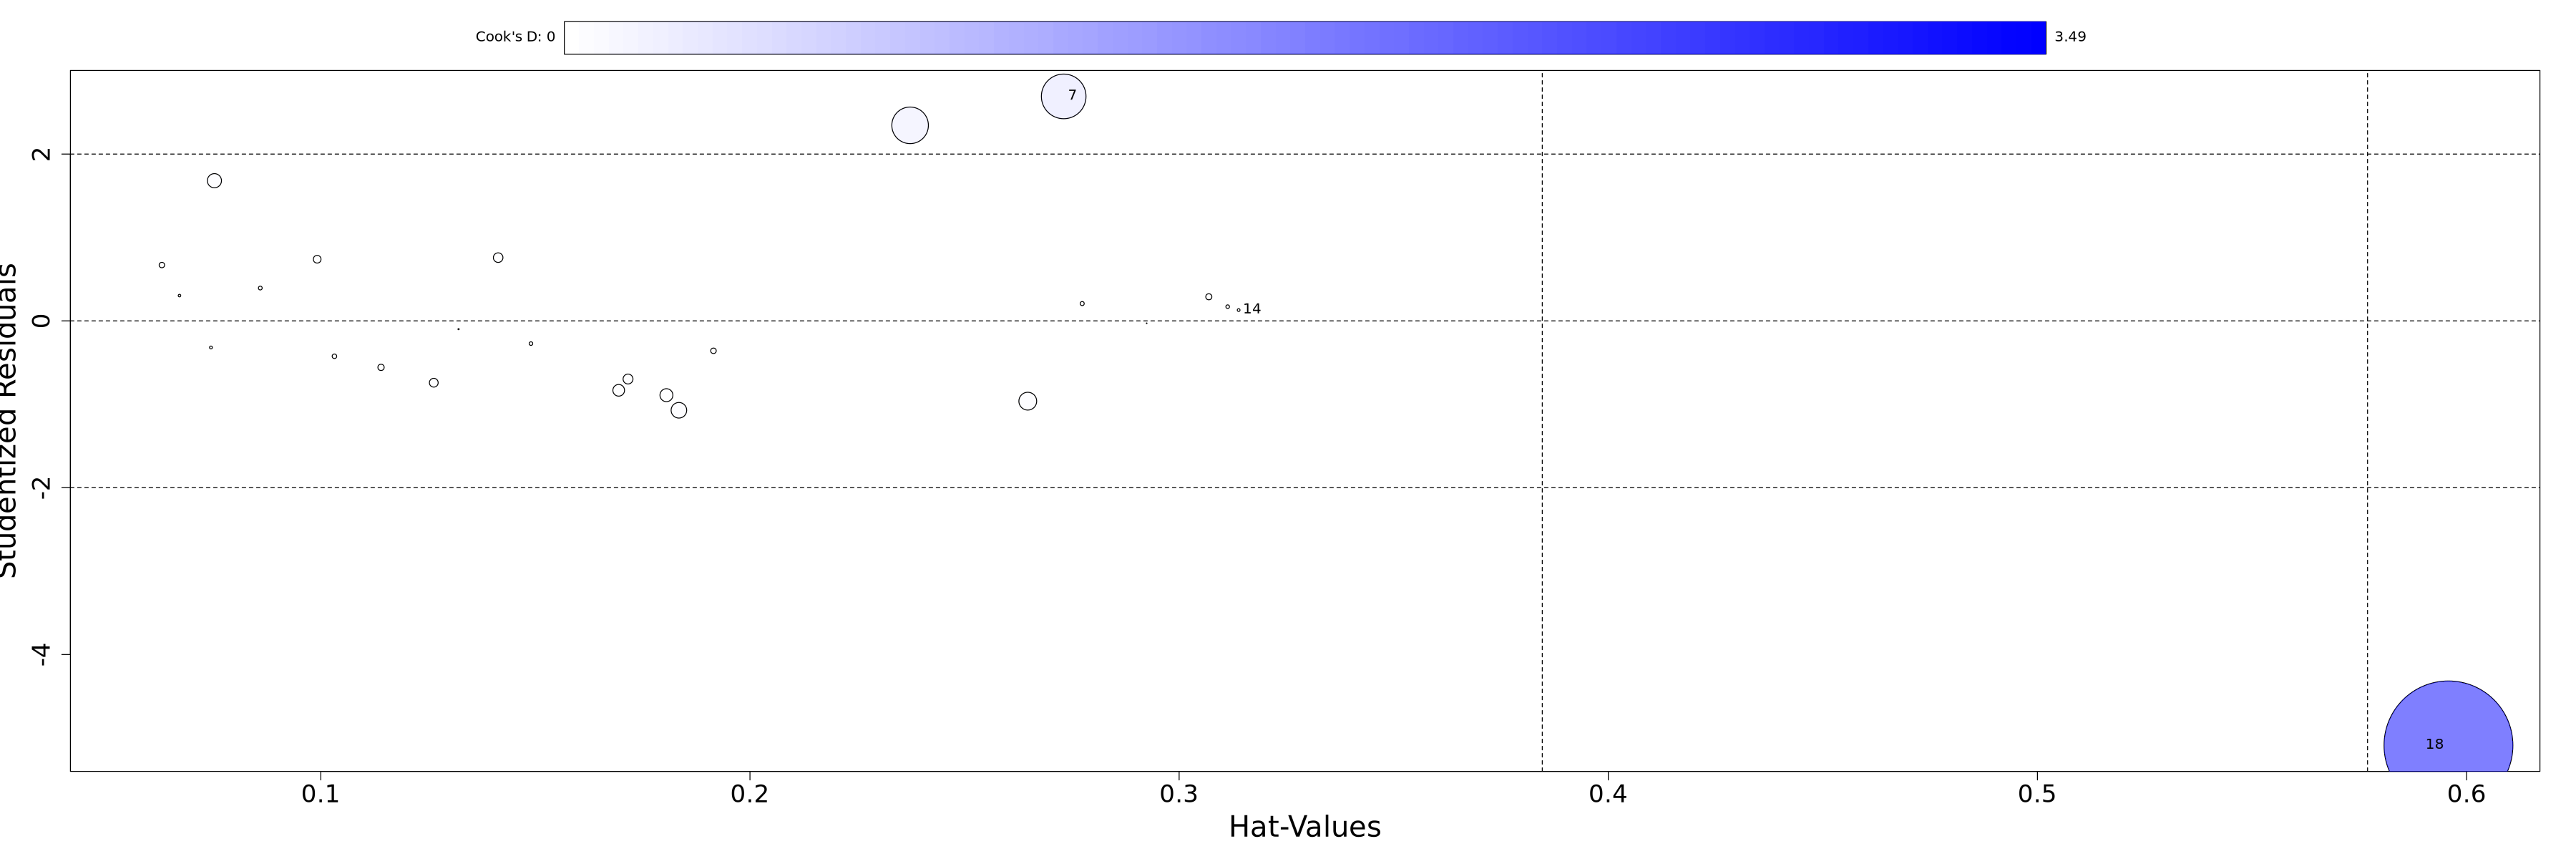

In [126]:
library(car)

# Influence plot with larger circles and font sizes
influencePlot(model, scale = 20, cex.axis = 1.7, cex.lab = 2)

#### Observation 7

* **Studentized Residual**: A value of 2.69 is moderately large but not extreme. It is within an acceptable range.
* **Cook's Distance**: A value of 0.42 is well below the threshold of 4/n (influence cutoff)
* **Leverage**: The leverage value of 0.27 is moderate.

* Observation 7 doesn’t appear to be problematic in terms of high influence. We can consider leaving it in the model as it does not seem to be causing any major issues.

#### Observation 14

* **Studentized Residual**: A value of 0.13 suggests that the residual is very small.
* **Cook's Distance**: The Cook’s Distance of 0.0016 is much lower than the threshold.
* **Leverage**: The leverage value of 0.31 is within the normal range and not high enough to raise concerns.

* Observation 14 does not appear to be influential or problematic in the model.

#### Observation 18

Given the large **studentized residual**, high **Cook's Distance**, and high **leverage**, **Observation 18** is likely an influential data point that could be distorting the results of our regression model.

In [127]:
# Inspect the row with index 18
wages_2016[18, ]

geo,values,gdp_per_capita,education,sea_access,eurozone
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Luxembourg,62037,96230,36.4,No,Yes


The row with index 18 corresponds to **Luxembourg**, and it appears as follows:

* **High GDP per capita**: Luxembourg has an exceptionally high GDP per capita (96,230), which could make it a high outlier in the dataset. This value is significantly higher than the GDP per capita of other countries, which might be skewing the regression model, especially when you examine how GDP per capita relates to wages.

* **High Wages**: Luxembourg also has very high wages (62,037), which is expected given its high GDP per capita. However, this can be seen as an extreme value when compared to other countries.

* **Landlocked but High Wages**: The fact that Luxembourg is landlocked might make it unusual in terms of its `sea_access` variable, especially since sea access has shown some significance in influencing wages (with an average wage difference of 6,827 higher for countries with sea access). However, since Luxembourg has high wages despite being landlocked, it seems to be an outlier on this variable as well.

We'll try to remove this row and see, how the model behaves

In [128]:
# Remove observation 18 from the dataset
wages_2016_cleaned <- wages_2016[-18, ]

# Re-run the model without the outlier
model_cleaned <- lm(values ~ gdp_per_capita + education + sea_access + eurozone, data = wages_2016_cleaned)

# Show the summary
summary(model_cleaned)


Call:
lm(formula = values ~ gdp_per_capita + education + sea_access + 
    eurozone, data = wages_2016_cleaned)

Residuals:
     Min       1Q   Median       3Q      Max 
-12563.3  -1858.3   -319.7   1772.9   7781.0 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     558.37867 3600.38199   0.155    0.878    
gdp_per_capita    1.03023    0.07163  14.382 5.21e-12 ***
education      -127.86133  155.42893  -0.823    0.420    
sea_accessYes  2489.63689 2423.25502   1.027    0.317    
eurozoneYes     317.82074 1935.27436   0.164    0.871    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4162 on 20 degrees of freedom
Multiple R-squared:  0.9346,	Adjusted R-squared:  0.9215 
F-statistic: 71.41 on 4 and 20 DF,  p-value: 1.489e-11


* **Residual standard error** decreased from **6154** to **4162**, indicating less overall error in the model.
* **Adjusted R-squared** increased from **0.879** to **0.922**, meaning the model now explains a greater proportion of the variance in wages.
* **F-statistic** increased from **38.41** to **71.41**, with an even more significant p-value, suggesting a better overall model fit.

---

* **GDP per capita (Estimate = 1.03, p < 0.001)**: Became stronger and more significant. For each €1 increase in GDP per capita, average wages increase by about €1.03 — the strongest and most consistent predictor.
* **Education (Estimate = -127.86, p = 0.42)**: Still not statistically significant, and the coefficient became more negative, suggesting a slight model rebalancing.
* **Sea access (Estimate = 2489.64, p = 0.317)**: The effect size decreased and is no longer close to significance — access to the sea now appears less impactful.
* **Eurozone membership (Estimate = 317.82, p = 0.871)**: Remains statistically insignificant.


Removing the outlier improved the model's accuracy and explanatory power. The regression results are now more stable, and the model appears to reflect the general pattern in the data better — without being overly influenced by one extreme observation.

**Examining Multicollinearity**

In [129]:
cor(wages_2016_cleaned[, c("gdp_per_capita", "education")])

,gdp_per_capita,education
gdp_per_capita,1.0000000,0.5513215
education,0.5513215,1.0000000


**0.55** between `gdp_per_capita` and `education`:
There is a **moderate positive linear relationship** between these two variables. As **GDP per capita increases**, **education levels also tend to increase**, and vice versa.

* A correlation of **0.55** is **not considered high enough** to indicate **severe multicollinearity**.
* **No need to remove** or combine variables at this stage based on this value alone.

To be more certain, the next step is to check **Variance Inflation Factor (VIF)** values

In [130]:
# Check for multicollinearity with VIF
vif(model_cleaned)

gdp_per_capita      education     sea_access       eurozone 
      1.444492       1.617635       1.138758       1.089455

* All variables have VIF values **well below 2**, which means:

  * There is **no concerning multicollinearity** in our model.
  * All predictors provide mostly independent information.

#### **Step 3 : Test the model assumptions**

| Assumption                    | What it Means                                                  | Why it Matters                                              |
| ----------------------------- | -------------------------------------------------------------- | ----------------------------------------------------------- |
| **1. Linearity**              | The relationship between predictors and the response is linear | Otherwise, model is misspecified                            |
| **2. Homoscedasticity**       | Constant variance of residuals across levels of fitted values  | Heteroscedasticity can bias standard errors                 |
| **3. Normality of residuals** | Residuals are normally distributed                             | Needed for valid p-values and confidence intervals          |
| **4. Independence**           | Residuals are not autocorrelated                               | Violations common in time series; leads to misleading stats |

**1. Linearity**

**Tool**: Residuals vs. Fitted plot

**What to Look For**:

  * A random scatter around the horizontal line.
  * **No curve or pattern** — that would suggest non-linearity.


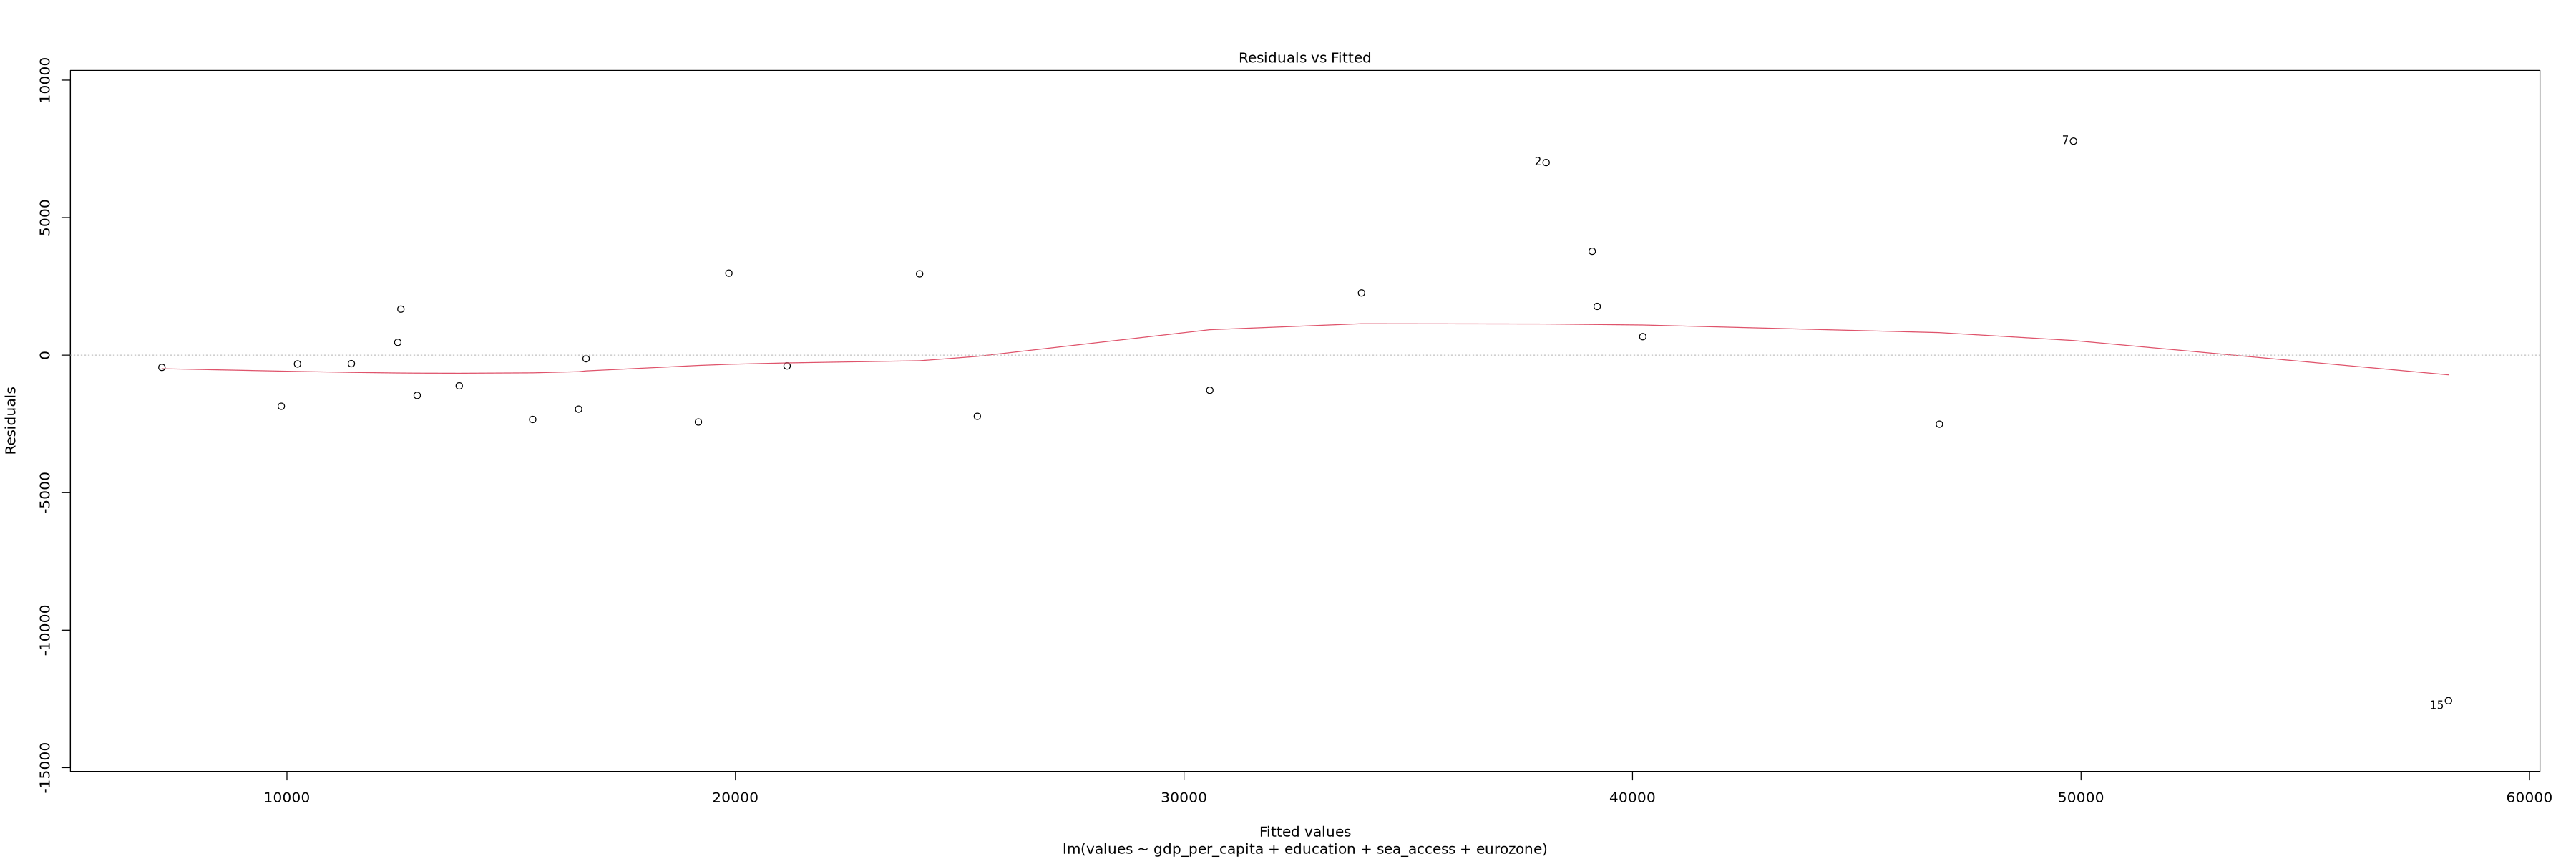

In [131]:
plot(model_cleaned, which = 1)  # Residuals vs Fitted

* The **red line (LOESS smoother)** is mostly flat with a small curve, which suggests **slight nonlinearity** but nothing too severe.
* In general, no clear pattern (e.g. strong curves or waves) is visible, which means the **linear relationship between predictors and response** is reasonably okay.
* The **spread of residuals** (the vertical distance of points from 0) seems to increase a bit at higher fitted values.
* This means **variance of errors may not be constant**, a sign of **heteroscedasticity**.

**2. Homoscedasticity (Constant variance)**

* **Tool**: Same plot (`which = 1`) + Breusch-Pagan test

* **What to Look For**:

  * **p-value > 0.05**: OK (no heteroscedasticity).
  * **p-value < 0.05**: Problem


In [132]:
library(lmtest)
bptest(model_cleaned)


	studentized Breusch-Pagan test

data:  model_cleaned
BP = 11.121, df = 4, p-value = 0.02524


* Since **p-value = 0.025 < 0.05**, this means we **reject the null hypothesis** of **homoscedasticity**.

**There is evidence of heteroscedasticity** — the residuals do **not** have constant variance.

So now we using **Robust Standard Errors**, which will be the correct way to interpret which variables are actually significant:

In [133]:
library(sandwich)
library(lmtest)
coeftest(model_cleaned, vcov = vcovHC(model_cleaned, type = "HC1"))


t test of coefficients:

                 Estimate Std. Error t value  Pr(>|t|)    
(Intercept)     558.37867 3505.00965  0.1593    0.8750    
gdp_per_capita    1.03023    0.10133 10.1668 2.394e-09 ***
education      -127.86133   87.37836 -1.4633    0.1589    
sea_accessYes  2489.63689 1657.58685  1.5020    0.1487    
eurozoneYes     317.82074 1799.16432  0.1766    0.8616    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


With robust standard errors to account for heteroscedasticity, GDP per capita remains a statistically significant predictor of wages. Education and sea access approach marginal significance but do not meet conventional thresholds. Eurozone membership remains insignificant.

**3. Normality of Residuals**

* **Tools**: Q-Q plot + Shapiro-Wilk test

* **What to Look For**:

  * Q-Q plot should follow the 45° line.
  * **Shapiro p-value > 0.05**: residuals are approximately normal.



	Shapiro-Wilk normality test

data:  residuals(model_cleaned)
W = 0.86693, p-value = 0.003756


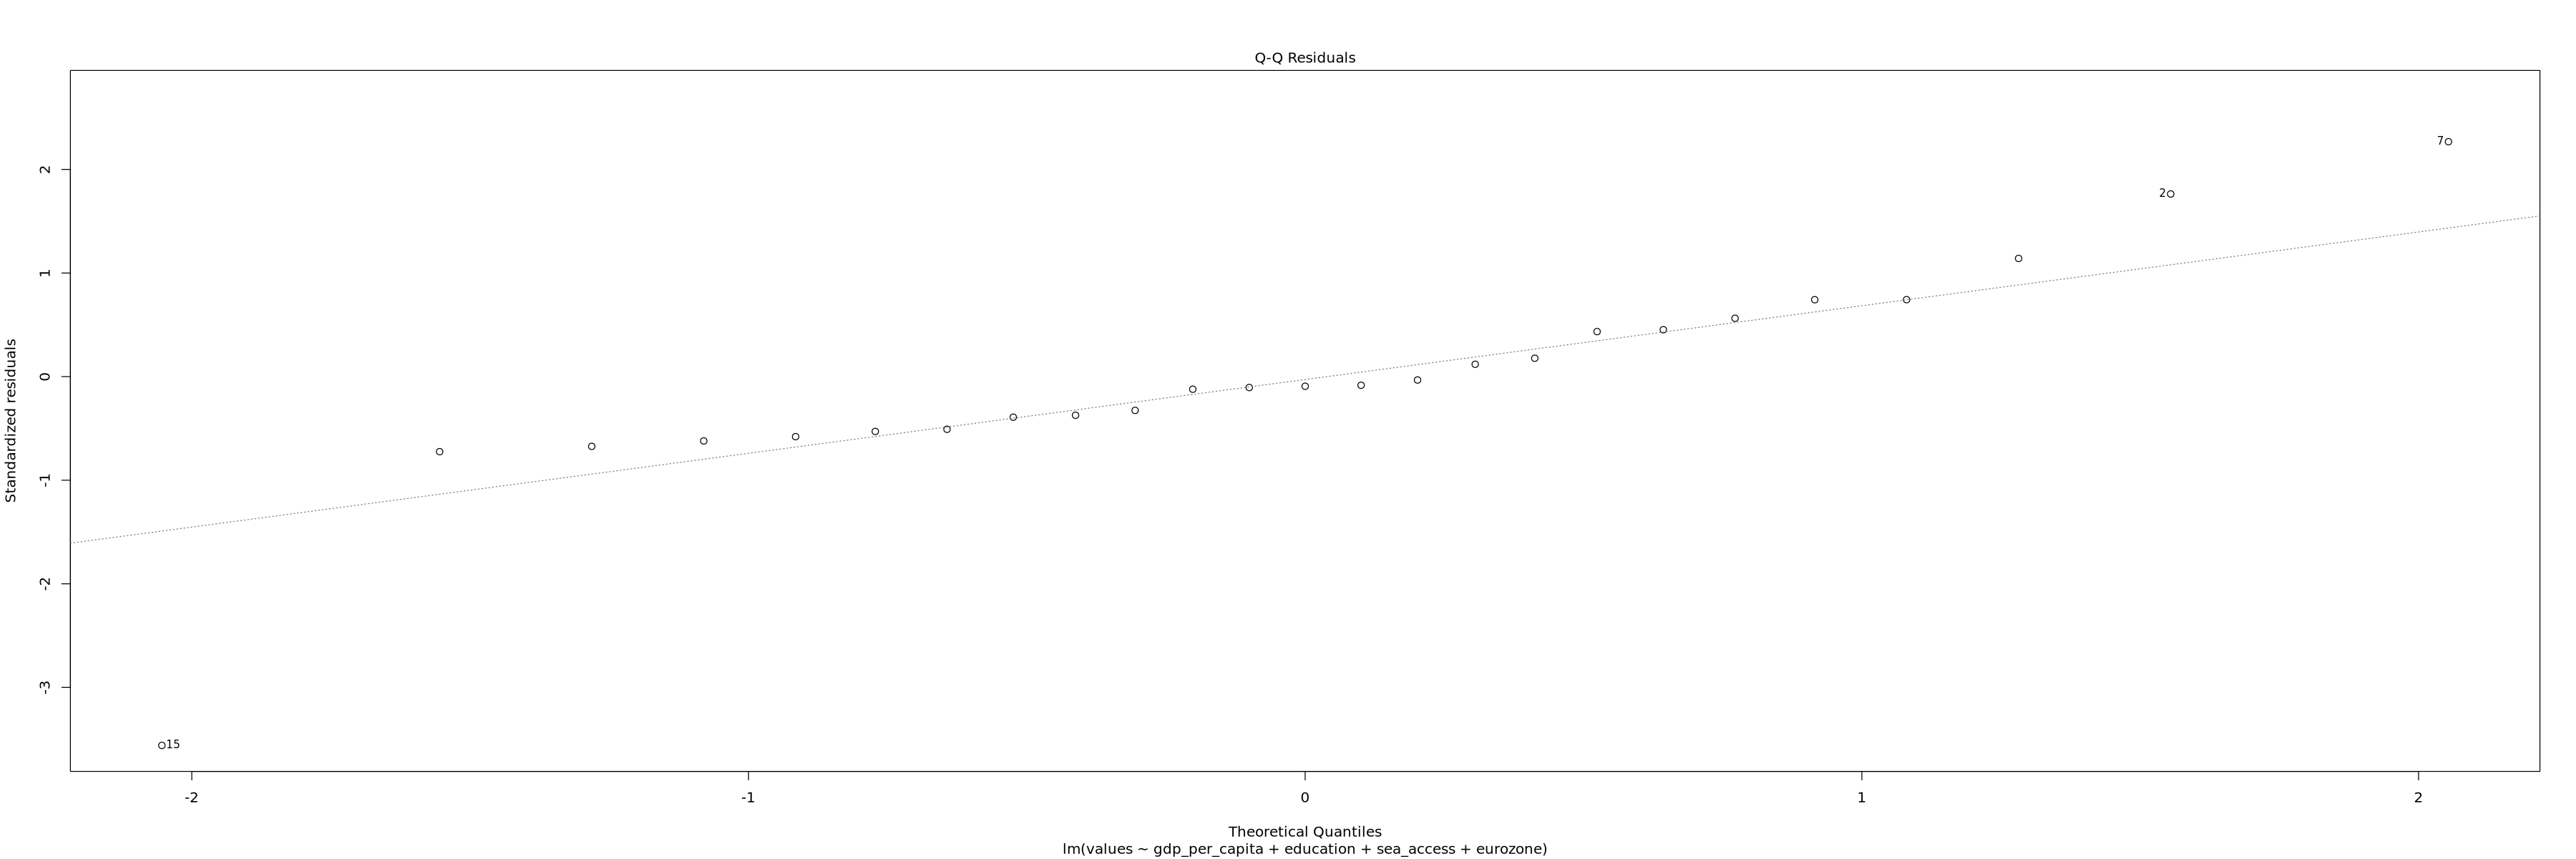

In [134]:
plot(model_cleaned, which = 2)      # Q-Q plot
shapiro.test(residuals(model_cleaned))  # Shapiro-Wilk test

* The **null hypothesis** is that the residuals are normally distributed.
* Since the **p-value is below 0.05**, we **reject the null hypothesis**.
* **Interpretation**: The residuals **do not follow a normal distribution** — a violation of one of the key assumptions of linear regression.


* The Q-Q plot shows a slightly **S-shaped curve** visually supports what the Shapiro-Wilk test found.
* That "S" means the **residuals have heavier tails** than a normal distribution — likely some **outliers or skewness**.


Non-normal residuals **don't invalidate much** the regression, especially if:

* We have a **reasonably large sample**.
* Our main goal is **inference** (e.g., coefficients + significance), and we're using **robust standard errors** (like we are).


But we'll try to do a log transformation to stabilize variance and improve normality.

In [104]:
model_log <- lm(log(values) ~ gdp_per_capita + education + sea_access + eurozone, data = wages_2016_cleaned)
summary(model_log)


Call:
lm(formula = log(values) ~ gdp_per_capita + education + sea_access + 
    eurozone, data = wages_2016_cleaned)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.59763 -0.06524  0.03226  0.09030  0.23725 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     8.851e+00  1.679e-01  52.723  < 2e-16 ***
gdp_per_capita  4.140e-05  3.340e-06  12.395 7.66e-11 ***
education      -6.954e-03  7.247e-03  -0.960  0.34874    
sea_accessYes   8.495e-02  1.130e-01   0.752  0.46089    
eurozoneYes     2.591e-01  9.023e-02   2.872  0.00943 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1941 on 20 degrees of freedom
Multiple R-squared:  0.919,	Adjusted R-squared:  0.9028 
F-statistic: 56.72 on 4 and 20 DF,  p-value: 1.241e-10



	Shapiro-Wilk normality test

data:  residuals(model_log)
W = 0.87901, p-value = 0.006595


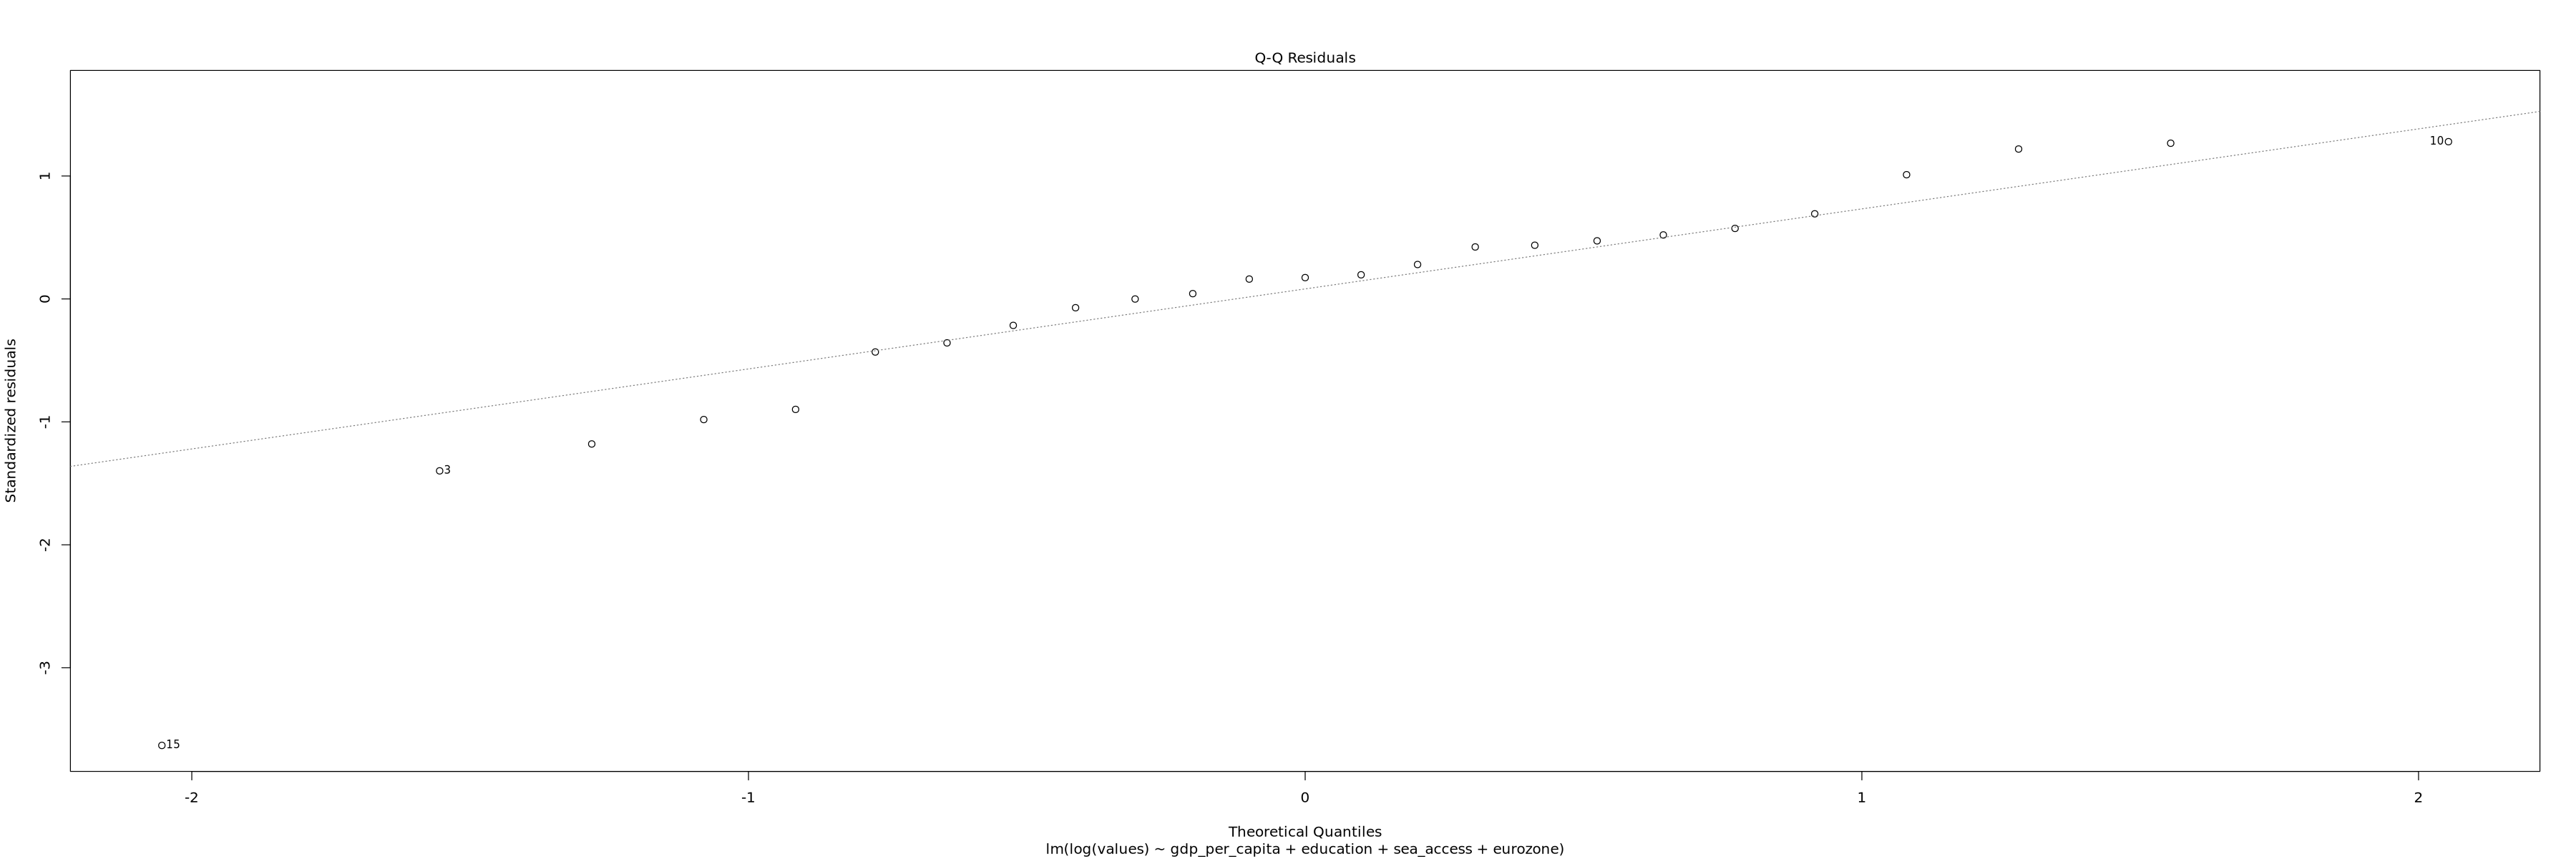

In [135]:
plot(model_log, which = 2)      # Q-Q plot
shapiro.test(residuals(model_log))  # Shapiro-Wilk test

In [137]:
bptest(model_log)


	studentized Breusch-Pagan test

data:  model_log
BP = 5.8733, df = 4, p-value = 0.2088


1. **Normality (Shapiro-Wilk):**

   * **W = 0.879**, **p = 0.0066** → still **significant**, so **residuals not perfectly normal**.
   * However, **it's slightly better than before** (previous W = 0.867, p = 0.0038).

2. **Homoscedasticity (Breusch-Pagan):**

   * **BP = 5.87**, **p = 0.21** → **not significant**, so **no evidence of heteroscedasticity**.
   * This is **a clear improvement** over the original model (which had p = 0.025).

Which model to stick with?

| Aspect               | Original Model                | Log Model                               |
| -------------------- | ----------------------------- | --------------------------------------- |
| **Normality**        | Worse (W = 0.867, p = 0.0038) | Slightly better (W = 0.879, p = 0.0066) |
| **Homoscedasticity** | Violated (p = 0.025)          | OK (p = 0.21)                           |
| **R² (Adjusted)**    | 0.922                         | 0.903                                   |
| **Interpretability** | Clear, original units         | Harder (log scale)                      |

---


* The **log model** **improves key assumptions**, especially **homoscedasticity**.
* The **loss in R² is small**, and we're gaining **statistical validity**.
So **the log model is the better choice** for inference.

#### **Step 4 : Find a final (sub-)model**

Odebereme z posledího modelu `sea_access` and `education`, which are not important due to p-value.

In [145]:
model_two <- lm(log(values) ~ gdp_per_capita + eurozone, data = wages_2016_cleaned)
summary(model_two)
coeftest(model_two, vcov = vcovHC(model_two, type = "HC1"))


Call:
lm(formula = log(values) ~ gdp_per_capita + eurozone, data = wages_2016_cleaned)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.61454 -0.05921  0.03834  0.09385  0.23511 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    8.775e+00  9.358e-02  93.768  < 2e-16 ***
gdp_per_capita 3.980e-05  2.754e-06  14.452 1.04e-12 ***
eurozoneYes    2.548e-01  8.568e-02   2.974    0.007 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1904 on 22 degrees of freedom
Multiple R-squared:  0.9142,	Adjusted R-squared:  0.9064 
F-statistic: 117.2 on 2 and 22 DF,  p-value: 1.856e-12



t test of coefficients:

                 Estimate Std. Error t value  Pr(>|t|)    
(Intercept)    8.7747e+00 1.1681e-01 75.1191 < 2.2e-16 ***
gdp_per_capita 3.9802e-05 4.8238e-06  8.2513 3.519e-08 ***
eurozoneYes    2.5482e-01 6.9201e-02  3.6823  0.001305 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



* ✅ **Both predictors are statistically significant**.
* ✅ **We’ve used robust SEs**, which gives you **more reliable p-values** in the presence of heteroskedasticity.
* ✅ The model explains **91.4% of the variance** in log(wages), which is strong.


✅ **Final Robust Regression Output Interpretation (model\_two)**

 1. **Intercept: 8.775**

* When `gdp_per_capita = 0` and the country is **not in the eurozone**, the expected **log of average wage** is **8.775**.
* Exponentiating:

  $$
  \exp(8.775) \approx 6,456
  $$

  ➤ So the **baseline average wage** is approximately **6,456 CZK/month** for a country with `gdp_per_capita = 0` and not in the eurozone.
  *(Interpretation of the intercept is mostly theoretical here since GDP per capita can’t actually be zero.)*

---

 2. **GDP per capita: 0.0000398**

* This coefficient tells us the effect of **a 1 CZK increase in GDP per capita** on log(wages).
* Exponentiate to interpret in percent terms:

  $$
  \exp(0.0000398) - 1 \approx 0.00398\% \text{ increase in wage}
  $$

  ➤ For every **1 CZK increase** in GDP per capita, the **average wage increases by \~0.004%**.

**For larger changes** (e.g., 10,000 CZK increase in GDP per capita):

$$
\exp(0.0000398 \times 10,000) - 1 \approx 48.6\%
$$

➤ A 10,000 CZK higher GDP per capita is associated with a **\~48.6% increase in wages**.

---

 3. **Eurozone membership: 0.25482**

* Binary variable: 1 if eurozone, 0 if not.
* Exponentiate:

  $$
  \exp(0.25482) \approx 1.29
  $$

  ➤ Being in the eurozone is associated with **\~29% higher average wages**, holding GDP per capita constant.


> The final model shows that wages in 2016 are strongly associated with a country’s GDP per capita and eurozone membership. Specifically:
>
> * Countries with higher GDP per capita have significantly higher wages.
> * Being part of the eurozone is associated with wages that are approximately **29% higher**, all else equal.
>
> Education and sea access were excluded from the model due to lack of significance. Robust standard errors were used to ensure reliable inference despite potential heteroskedasticity.
